<div style='padding:15px;color:#030aa7;font-size:240%;text-align: center;font-style: italic;font-weight: bold;font-family: Georgia, serif'>fashionMNIST</div>
<div style='text-align: center'>
    <img src="https://raw.githubusercontent.com/rbizoi/DeepLearning/refs/heads/main/images/fashionMNIST.png" width="256">
</div>  

> https://www.larousse.fr/dictionnaires/francais/inf%C3%A9rence/42907<br><br>

>> **inférence** : Opération par laquelle on passe d'une assertion considérée comme vraie à une autre assertion au moyen d'un système de règles qui rend cette deuxième assertion également vraie.<br>

>> **Inférence statistique** : Ensemble des méthodes permettant de formuler en termes probabilistes un jugement sur une population à partir des résultats observés sur un échantillon extrait au hasard de cette population.<br>
 

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation du document</div></b>

In [1]:
import os
# import json
# @param ["tensorflow", "jax", "torch"]
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['KERAS_BACKEND'] = 'tensorflow'  
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
# os.environ['TF_XLA_FLAGS']='--tf_xla_auto_jit=1,--tf_xla_always_defer_compilation=true'
# os.environ['XLA_FLAGS']='--xla_backend_optimization_level=0,--xla_gpu_autotune_level=4,--xla_gpu_disable_ptxas_optimizations=true,--xla_gpu_use_cudnn_batchnorm_level=2'
# os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
os.environ['TF_CPP_MIN_LOG_LEVEL']='5'

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Import libriries </div></b>

In [2]:
import numpy as np, pandas as pd, seaborn as sns, warnings, os, sys, pickle, time
from matplotlib import pyplot as plt
from datetime import datetime as dt

import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D


from sklearn.preprocessing import label_binarize
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                            precision_score, recall_score, f1_score, fbeta_score, jaccard_score, \
                            precision_recall_curve, average_precision_score, balanced_accuracy_score, \
                            classification_report,roc_auc_score

tf.get_logger().setLevel('ERROR')# Suppress TensorFlow logging (2)

In [4]:
print("Tensorflow\t : %s\tCUDA %s\tGPU %s\tXLA %s\nKeras\t\t : %s\nPandas\t\t : %s\nNumPy\t\t : %s"%
      (tf.__version__, 
       tf.test.is_built_with_cuda(), 
       tf.test.is_built_with_gpu_support(), 
       tf.test.is_built_with_xla(), 
       tf.keras.__version__, 
       pd.__version__, 
       np.__version__))

Tensorflow	 : 2.17.0	CUDA True	GPU True	XLA True
Keras		 : 3.6.0
Pandas		 : 2.2.2
NumPy		 : 1.26.4


# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Initialisation des GPUs presents</div></b>

In [ ]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) >  0 :
    for i, gpu in enumerate(physical_devices):
        tf.config.experimental.set_memory_growth(physical_devices[i], True)

    strategy = tf.distribute.experimental.CentralStorageStrategy()
    print('Le système est initialisé avec {0:d} GPUs'.format(strategy.num_replicas_in_sync))

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Outils du document</div></b>

In [6]:
palette = [
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

In [7]:
nom_projet                = "06.L'optimisation du modèle personnalise 01--fashionMNIST_Categorical"
repertoireProjet          = os.getcwd()
repertoireEnregistrement  = repertoireProjet +'/'+nom_projet+ '/repertoire.images'
repertoireSauvegardes     = repertoireProjet +'/'+nom_projet+ '/repertoire.sauvegardes'

def controleExistenceRepertoire(directory, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(directory)
    if path_exists:
        if not os.path.isdir(directory):
            raise Exception("Trouvé le nom "+directory+" mais c'est un fichier, pas un répertoire")
            return False
        return True
    if create_if_needed:
        os.makedirs(directory)
        
controleExistenceRepertoire(repertoireEnregistrement)
controleExistenceRepertoire(repertoireSauvegardes)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    plt.savefig(os.path.join(repertoireEnregistrement,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')
    
def sauvegarderModelPoids(model, fichierPoids, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez les poids du modèle Keras."""
    if fichierPoids != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichierPoids))
        model.save_weights(nomFichier)

def sauvegarderModel(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Enregistrez le modèle Keras."""
    if fichier != None:
        controleExistenceRepertoire(repertoireSauvegardes)
        nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
        model.save(nomFichier)

def lectureModelPoids(model, fichier, repertoireSauvegardes=repertoireSauvegardes):
    """Si le fichier existe, il est chargé et retourne True, sinon retourne False."""
    nomFichier = os.path.join(repertoireSauvegardes, '{}.keras'.format(fichier))
    if os.path.exists(nomFichier):
        if os.path.isfile(nomFichier):
            model.load_weights(nomFichier)
            return True
    return False

def sauvegardeHistorique(model,
                         repertoireSauvegardes,
                         nomSauvegarde='one_hidden_layer_history_batch_size_1'):

    history = pd.DataFrame( model.history)
    history.reset_index(inplace=True)
    history.rename(columns={'index':'epoch'},inplace=True)
    history.to_parquet(os.path.join(repertoireSauvegardes,f'{nomSauvegarde}.gzip'),compression='gzip', engine='pyarrow') 
    return history

def afficheHistoriqueEntrainement(history, palette, nom='afficheHistoriqueEntrainement'):
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(48,16));
    markersize = 8
    linewidth=2
    
    graph = sns.lineplot(x='epoch', 
                         y='accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_accuracy',  
                         data=history,
                         ax=ax[0],      
                         label='val_accuracy',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    
    graph = sns.lineplot(x='epoch', 
                         y='loss',  
                         data=history,
                         ax=ax[1],      
                         label='loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[0],
                         );
    graph = sns.lineplot(x='epoch', 
                         y='val_loss',  
                         data=history,
                         ax=ax[1],      
                         label='val_loss',
                         err_style=None, 
                         marker='o',
                         markersize=markersize,
                         linewidth=linewidth,
                         color=palette[1],
                         );
    sauvegarderImage(nom)

def afficheMatriceConfusion(observations,predictions,dictLabels):
    plt.figure(figsize=(8,8))
    sns.set(font_scale=1.5)
    sns.heatmap(pd.crosstab(observations,predictions), 
                fmt= '.0f',
                linewidths=0.3,
                #vmax=1.0, 
                square=True, 
                cmap=plt.cm.Blues,
                linecolor='white', 
                annot=True,
                cbar=False,
                xticklabels=dictLabels.values(), 
                yticklabels=dictLabels.values()
               );
    plt.xlabel('Observations', fontsize = 18);
    plt.ylabel('Prédictions', fontsize = 18);
    sauvegarderImage('afficheMatriceConfusion')

def executeApprentissageChoixClassifieurs(model,
                                          X_test,
                                          y_test,
                                          label_dict,
                                          couleurs,
                                          nom_essai = 'initial'
                                         ):
    
    def afficheCourbes(vraisPositifs,fauxPositifs,aucROCt,precisions,sensibilites,avgPrecRec,nbClasses,lw,label_dict):
        plt.figure(figsize=(24, 24));
        for i, color in zip(range(nbClasses), palette):
            plt.plot(fauxPositifs[i], vraisPositifs[i], color=color, lw=lw,
                     label=' ' + label_dict[i] + ' (AUC = {1:0.8f})'
                                                             ''.format(i, aucROCt[i]))
    
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('Taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
        plt.ylabel('Taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
        plt.title('Courbe ROC (Receiver Operating Caracteristic) -- ',size=20)
        plt.legend(loc="lower right"); #, fontsize='large'
        sauvegarderImage('Courbe ROC')
        
        plt.figure(figsize=(24,24));
    
        f_scores = np.linspace(0.2, 0.9, num=8)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    
        for i, color in zip(range(nbClasses), palette):
            plt.step(sensibilites[i], 
                         precisions[i], 
                         where='post', 
                         color=color, 
                         lw=lw, 
                         label=f"{label_dict[i]}(APR = {avgPrecRec[label_dict[i]]:0.8f})"
                    )
            plt.fill_between(sensibilites[i], precisions[i], step='post', alpha=0.05)            
    
            # plt.plot(fauxPositifs[i], vraisPositifs[i], color=color, lw=lw,
            #          label=' ' + label_dict[i] + ' (AUC = {1:0.8f})'
            #                                                  ''.format(i, aucROCt[i]))        
    
        plt.plot([0, 1], [0, 1], 'k--', lw=lw)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])        
        plt.xlabel('Sensibilité/Rappel(Recall) = VP / (VP + FN)',size=18)
        plt.ylabel('Précision = VP / (VP + FP)',size=18)        
        plt.title('Courbe Précision-Rappel',size=20)
        plt.legend(loc="lower right") # , fontsize = 'large'
        sauvegarderImage('Courbe Précision-Rappel')
    
    cvF1, cvF1SD, cvAccuracy, cvAccSD, aucROC, avgPrecRec, accuracy, balanced_accuracy, logloss, hammingloss, precision, sensibilite, \
    f1, f2, f05, jaccard, vrais_negatifs, faux_positifs, faux_negatifs, vrais_positifs, total_positifs, aucROCtn = \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(),\
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    #
    oneloss, precision_micro, precision_macro, precision_weighted, \
    sensibilite_macro, sensibilite_micro, sensibilite_weighted, \
    f1_micro, f1_macro, f1_weighted,f2_micro,f2_macro,f2_weighted,f05_micro,f05_macro,f05_weighted = \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), \
        dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    
    fauxPositifs, vraisPositifs, precisions, sensibilites, aucROCt, pr_auc, tauxROC, tauxPR = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()        
    
    
    lw = 1
    # couleurs    = sns.hls_palette(len(classifieursDict.keys()), l=.4, s=.9)
    nbClasses   = len(dictLabels.keys())
    listClasses = list(dictLabels.keys())
    
    y_testA  = label_binarize(y_test, classes=listClasses)
    plt.figure(figsize=(18,18))
    
    
    t1 = time.time()  
    classifier = model
    
    # y_score     = model.predict_proba(X_test)
    # y_pred      = model.predict(X_test)
    y_score     = model.predict(X_test)
    y_pred      = np.argmax(y_score, axis=-1) 
    y_predA     = label_binarize(y_pred, classes=listClasses)
    
    accuracy['global']              = accuracy_score(y_test, y_pred)
    balanced_accuracy['global']     = balanced_accuracy_score(y_test, y_pred)
    precision['global']             = precision_score(y_test, y_pred, average='weighted')
    sensibilite['global']           = recall_score(y_test, y_pred, average='weighted')
    
    f1['global']                    = f1_score(y_test, y_pred, average='weighted')
    f2['global']                    = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    f05['global']                   = fbeta_score(y_test, y_pred, beta=0.5, average='weighted')
    
    vrais_negatifs['global']        = 0
    faux_positifs ['global']        = 0
    faux_negatifs ['global']        = 0
    vrais_positifs['global']        = 0
    total_positifs['global']        = 0
    
    
    aucROC['global'] = roc_auc_score(y_test, y_score, multi_class='ovr')
    
    for i in range(nbClasses):
        fauxPositifs[i], vraisPositifs[i], tauxROC[i] = roc_curve(y_testA[:, i], y_score[:, i])
        aucROCt[i]                                    = auc(fauxPositifs[i], vraisPositifs[i])
        precisions[i], sensibilites[i], tauxPR[i]     = precision_recall_curve(y_testA[:, i], y_score[:, i])
    
        aucROC[label_dict[i]]                = aucROCt[i]
        avgPrecRec[label_dict[i]]            = average_precision_score(y_testA[:, i], y_score[:, i])
        accuracy[label_dict[i]]              = accuracy_score(y_testA[:, i], y_predA[:, i])
        balanced_accuracy[label_dict[i]]     = balanced_accuracy_score(y_testA[:, i],y_predA[:, i])
        logloss[label_dict[i]]               = log_loss(y_testA[:, i], y_predA[:, i])
        hammingloss[label_dict[i]]           = hamming_loss(y_testA[:, i], y_predA[:, i])
        precision[label_dict[i]]             = precision_score(y_testA[:, i], y_predA[:, i])
        sensibilite[label_dict[i]]           = recall_score(y_testA[:, i], y_predA[:, i])
        f1[label_dict[i]]                    = f1_score(y_testA[:, i], y_predA[:, i])
        f2[label_dict[i]]                    = fbeta_score(y_testA[:, i], y_predA[:, i], beta=2)
        f05[label_dict[i]]                   = fbeta_score(y_testA[:, i], y_predA[:, i], beta=0.5)
      
        jaccard[label_dict[i]]               = jaccard_score(y_testA[:, i], y_predA[:, i])
        vrais_negatifs[label_dict[i]]        = confusion_matrix(y_testA[:, i], y_predA[:, i])[0, 0]
        faux_positifs[label_dict[i]]         = confusion_matrix(y_testA[:, i], y_predA[:, i])[0, 1]
        faux_negatifs[label_dict[i]]         = confusion_matrix(y_testA[:, i], y_predA[:, i])[1, 0]
        vrais_positifs[label_dict[i]]        = confusion_matrix(y_testA[:, i], y_predA[:, i])[1, 1]
        total_positifs[label_dict[i]]        = vrais_positifs[label_dict[i]] + faux_negatifs [label_dict[i]]
        vrais_negatifs['global']              += vrais_negatifs[label_dict[i]]
        faux_positifs ['global']              += faux_positifs [label_dict[i]]
        faux_negatifs ['global']              += faux_negatifs [label_dict[i]]
        vrais_positifs['global']              += vrais_positifs[label_dict[i]]
    
    
    total_positifs['global'] = vrais_positifs['global'] + faux_negatifs ['global']
    
    
    fauxPositifs["micro"], vraisPositifs["micro"], _ = roc_curve(y_testA.ravel(), y_score.ravel())
    aucROCt["micro"]                                 = auc(fauxPositifs["micro"], vraisPositifs["micro"])
    
    listFauxPositifs = np.unique(np.concatenate([fauxPositifs[i] for i in range(nbClasses)]))
    moyenneVraisPositifs = np.zeros_like(listFauxPositifs)
    for i in range(nbClasses):
        moyenneVraisPositifs += np.interp(listFauxPositifs, fauxPositifs[i], vraisPositifs[i])
    
    moyenneVraisPositifs /= nbClasses
    
    fauxPositifs["macro"], vraisPositifs["macro"] = listFauxPositifs, moyenneVraisPositifs
    aucROCt["macro"] = auc(fauxPositifs["macro"], vraisPositifs["macro"])
    # aucROC['global'] = aucROCt["macro"]  # (aucROCt["micro"],aucROCt["macro"])
    
    avgPrecRec['global'] = average_precision_score(y_testA.ravel(), y_score.ravel(), average='weighted')
    
    afficheCourbes(vraisPositifs,fauxPositifs,aucROCt,precisions,sensibilites,avgPrecRec,nbClasses,lw,label_dict);
    
    print ("Area under the ROC curve : %0.4f" % aucROC['global'],end='\t--\t')
    print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))
        
    resultats = pd.DataFrame(pd.Series(aucROC), columns=["aucROC"])
    resultats["avgPrecRec"]              = pd.Series(avgPrecRec)
    resultats["f1"]                      = pd.Series(f1)
    resultats["f2"]                      = pd.Series(f2)
    resultats["f05"]                     = pd.Series(f05)
    resultats["accuracy"]                = pd.Series(accuracy)
    
    resultats["precision"]               = pd.Series(precision)
    resultats["sensibilite"]             = pd.Series(sensibilite)
    resultats["vrais_positifs"]          = pd.Series(vrais_positifs)
    resultats["vrais_negatifs"]          = pd.Series(vrais_negatifs)
    resultats["faux_positifs"]           = pd.Series(faux_positifs)
    resultats["faux_negatifs"]           = pd.Series(faux_negatifs)
    resultats["total_positifs"]          = pd.Series(total_positifs)
    
    resultats.reset_index(inplace=True)
    resultats.rename(columns={"index": "Classe"}, inplace=True)
    resultats['essai'] = nom_essai
    return resultats

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Lecture des données</div></b>

In [8]:
dictLabels = {0:'T-shirt',
              1:'Pantalon',
              2:'Pull',
              3:'Robe',
              4:'Manteau',
              5:'Sandale',
              6:'Chemise',
              7:'Baskets',
              8:'Sac',
              9:'Bottines'}

In [9]:
random_seed = 42
np.random.seed(random_seed)

# load fashion MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width
number_of_classes = len(dictLabels.keys())

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# scale data to range [-0.5, 0.5]
X_train -= 0.5
X_test -= 0.5

X_train = X_train.reshape((X_train.shape[0], number_of_pixels))
X_test  = X_test.reshape((X_test.shape[0], number_of_pixels))

# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
y_train = tf.keras.utils.to_categorical(y_train, num_classes=number_of_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=number_of_classes)

# <b><div style='padding:18px;background-color:#d8dcd6;color:#030aa7;font-size:130%; border-radius:12px 12px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Création et compilation des modèles</div></b>

In [10]:
epochs=128
batch_size = 256
initial_lrate = 1e-3
min_lrate = 1e-5

drop_lrate = 0.5
epochs_drop = epochs * 0.1

In [11]:
print(
f"""
Les paramètres de l’exécution :
image_size              = ({image_height},{image_width},1)
number_of_pixels        = {number_of_pixels }
number_of_classes       = {number_of_classes}
----------------------------------------------
epochs                  = {epochs       }
batch_size              = {batch_size   }
----------------------------------------------
inital LearningRate     = {initial_lrate}
min    LearningRate     = {min_lrate}
""")


Les paramètres de l’exécution :
image_size              = (28,28,1)
number_of_pixels        = 784
number_of_classes       = 10
----------------------------------------------
epochs                  = 128
batch_size              = 256
----------------------------------------------
inital LearningRate     = 0.001
min    LearningRate     = 1e-05



In [12]:
def compileModel(model,initial_lrate):
    model.compile(
            optimizer=tf.keras.optimizers.Adam(initial_lrate), 
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
        )
    return model

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Modèle avec une couche cachée</div></b>

In [13]:
def make_model_une_couche_cachee(number_of_pixels,number_of_classes, initial_lrate):
    model = Sequential()
    model.add(Dense(number_of_pixels, 
                    activation='relu',
                    input_shape=[number_of_pixels]))

    model.add(Dense(number_of_classes, 
                    activation='softmax'))

    return compileModel(model,initial_lrate)

# make the model
model = make_model_une_couche_cachee(number_of_pixels,number_of_classes, initial_lrate)

In [14]:
def make_model_personalise(number_of_pixels, dropout_per_layer, input_shape, number_of_classes, initial_lrate):
    model = Sequential()
    for i in range(len(number_of_pixels)):
        kwargs = { 'kernel_initializer': 'glorot_normal', 'activation': 'relu' }
        if i==0:
            kwargs['input_shape'] = [input_shape]
        if dropout_per_layer[i]:
            kwargs['kernel_constraint'] = tf.keras.constraints.MaxNorm()
        
        model.add(Dense(number_of_pixels[i], **kwargs))
        
        if dropout_per_layer[i]: model.add(Dropout(0.2))
            
    model.add(Dense(number_of_classes, activation='softmax'))

    return compileModel(model,initial_lrate)

# make the model
model = make_model_personalise(number_of_pixels=[256,128,64,32,16], 
                               dropout_per_layer=[True,True,True,True,True],
                               input_shape=number_of_pixels,
                               number_of_classes=number_of_classes, 
                               initial_lrate=initial_lrate)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,890 (956.60 KB)

 Trainable params: 244,890 (956.60 KB)

 Non-trainable params: 0 (0.00 B)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Exécution de l’apprentissage</div></b>

In [15]:
# learning rate scheduler
def step_decay(epoch):
    lrate = (initial_lrate - min_lrate ) * drop_lrate**((1+epoch)/epochs_drop) + min_lrate
    return lrate
# learning schedule callback

learningRate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [16]:
def execute_apprentissage_history(model, 
                                  X_train, y_train, X_test, y_test,
                                  filename='generic-filename', 
                                  epochs=256, 
                                  batch_size=256, 
                                  verbosity=1):
    kwargs = { 'validation_data': (X_test, y_test), 
               'epochs': epochs,
               'batch_size': batch_size, 
               'verbose': verbosity,
               'callbacks' : learningRate }
    history = model.fit(X_train, y_train, **kwargs)
    fichier = os.path.join(repertoireSauvegardes, 
                           f'Keras-09-MNIST-OptimisationModele.{filename}-{epochs:04d}-epochs.keras')
    model.save(fichier)
    return history

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Exécution de l’apprentissage avec plusieurs batch_size </div></b>

In [17]:
history_list = []
time_list = []
for batchsize in [32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8]:
    model = make_model_personalise(number_of_pixels=[256,128,64,32,16], 
                                   dropout_per_layer=[True,True,True,True,True],
                                   input_shape=number_of_pixels,
                                   number_of_classes=number_of_classes, 
                                   initial_lrate=initial_lrate)
    
    start_time = time.time()
    history = execute_apprentissage_history(model, 
                                  X_train, y_train, X_test, y_test,
                                  filename=f'model_une_couche_cachee-bs-{batchsize}', 
                                  epochs=256, 
                                  batch_size=batchsize, 
                                  verbosity=0)
    end_time = time.time()
    elapsed_time = end_time-start_time
    history_list.append(history)
    time_list.append(elapsed_time)  
    print(f"""
    --------------------------------------------------------------------------------------------------------
    batchsize={batchsize:5d} durée={elapsed_time:0.2f} loss={(history.history['loss'][255]):0.4f} accuracy={(history.history['accuracy'][255]):0.4f}
        val_loss={history.history['val_loss'][255]:0.4f}  min(val_loss)={min(history.history['val_loss']):0.4f} val_accuracy={history.history['val_accuracy'][255]:0.4f} max(val_accuracy)={max(history.history['val_accuracy']):0.4f}        
    --------------------------------------------------------------------------------------------------------    
    """)

I0000 00:00:1751788566.363142   10104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



    --------------------------------------------------------------------------------------------------------
    batchsize=32768 durée=26.05 loss=1.1201 accuracy=0.6048
        val_loss=0.8387  min(val_loss)=0.8387 val_accuracy=0.7679 max(val_accuracy)=0.7679        
    --------------------------------------------------------------------------------------------------------    
    

    --------------------------------------------------------------------------------------------------------
    batchsize=16384 durée=24.76 loss=0.7251 accuracy=0.7547
        val_loss=0.5045  min(val_loss)=0.5045 val_accuracy=0.8290 max(val_accuracy)=0.8292        
    --------------------------------------------------------------------------------------------------------    
    

    --------------------------------------------------------------------------------------------------------
    batchsize= 8192 durée=27.50 loss=0.5383 accuracy=0.8282
        val_loss=0.4202  min(val_loss)=0.4202 val_accura

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Sauvegarde résultats</div></b>

In [18]:
with open(os.path.join(repertoireSauvegardes,'resultats_execution_apprentissage'), 'wb') as fichier:
    pickle.dump(history_list, fichier)
    pickle.dump(time_list, fichier)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Lecture résultats</div></b>

In [19]:
with open(os.path.join(repertoireSauvegardes,'resultats_execution_apprentissage'), 'rb') as fichier:
    history_list = pickle.load(fichier)
    time_list    = pickle.load(fichier)

## <b><div style='padding:15px;background-color:#d8dcd6;color:#030aa7;font-size:100%; border-radius:10px 10px; box-shadow: 8px 8px 8px #042b4c;text-align: left'>Affichage résultats</div></b>

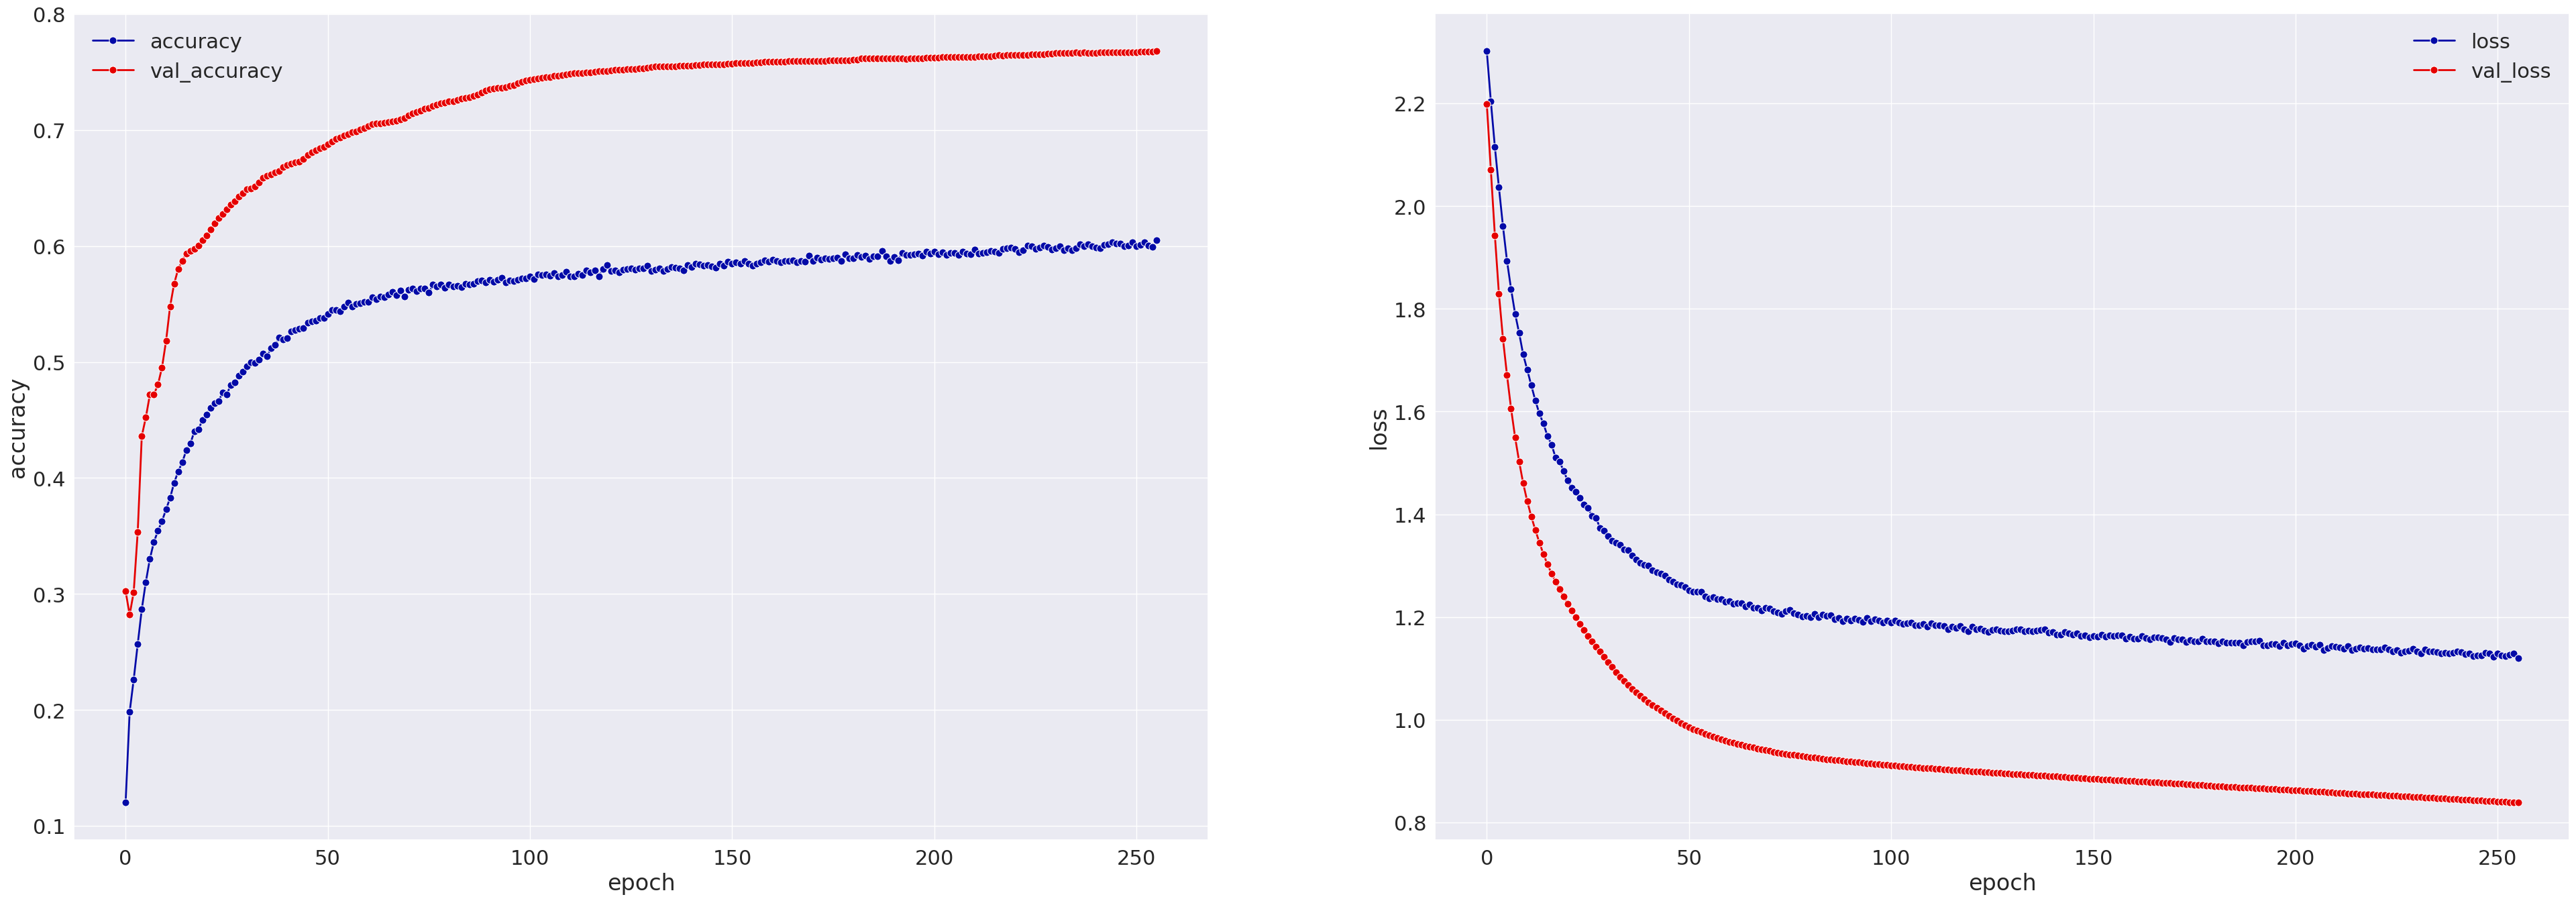

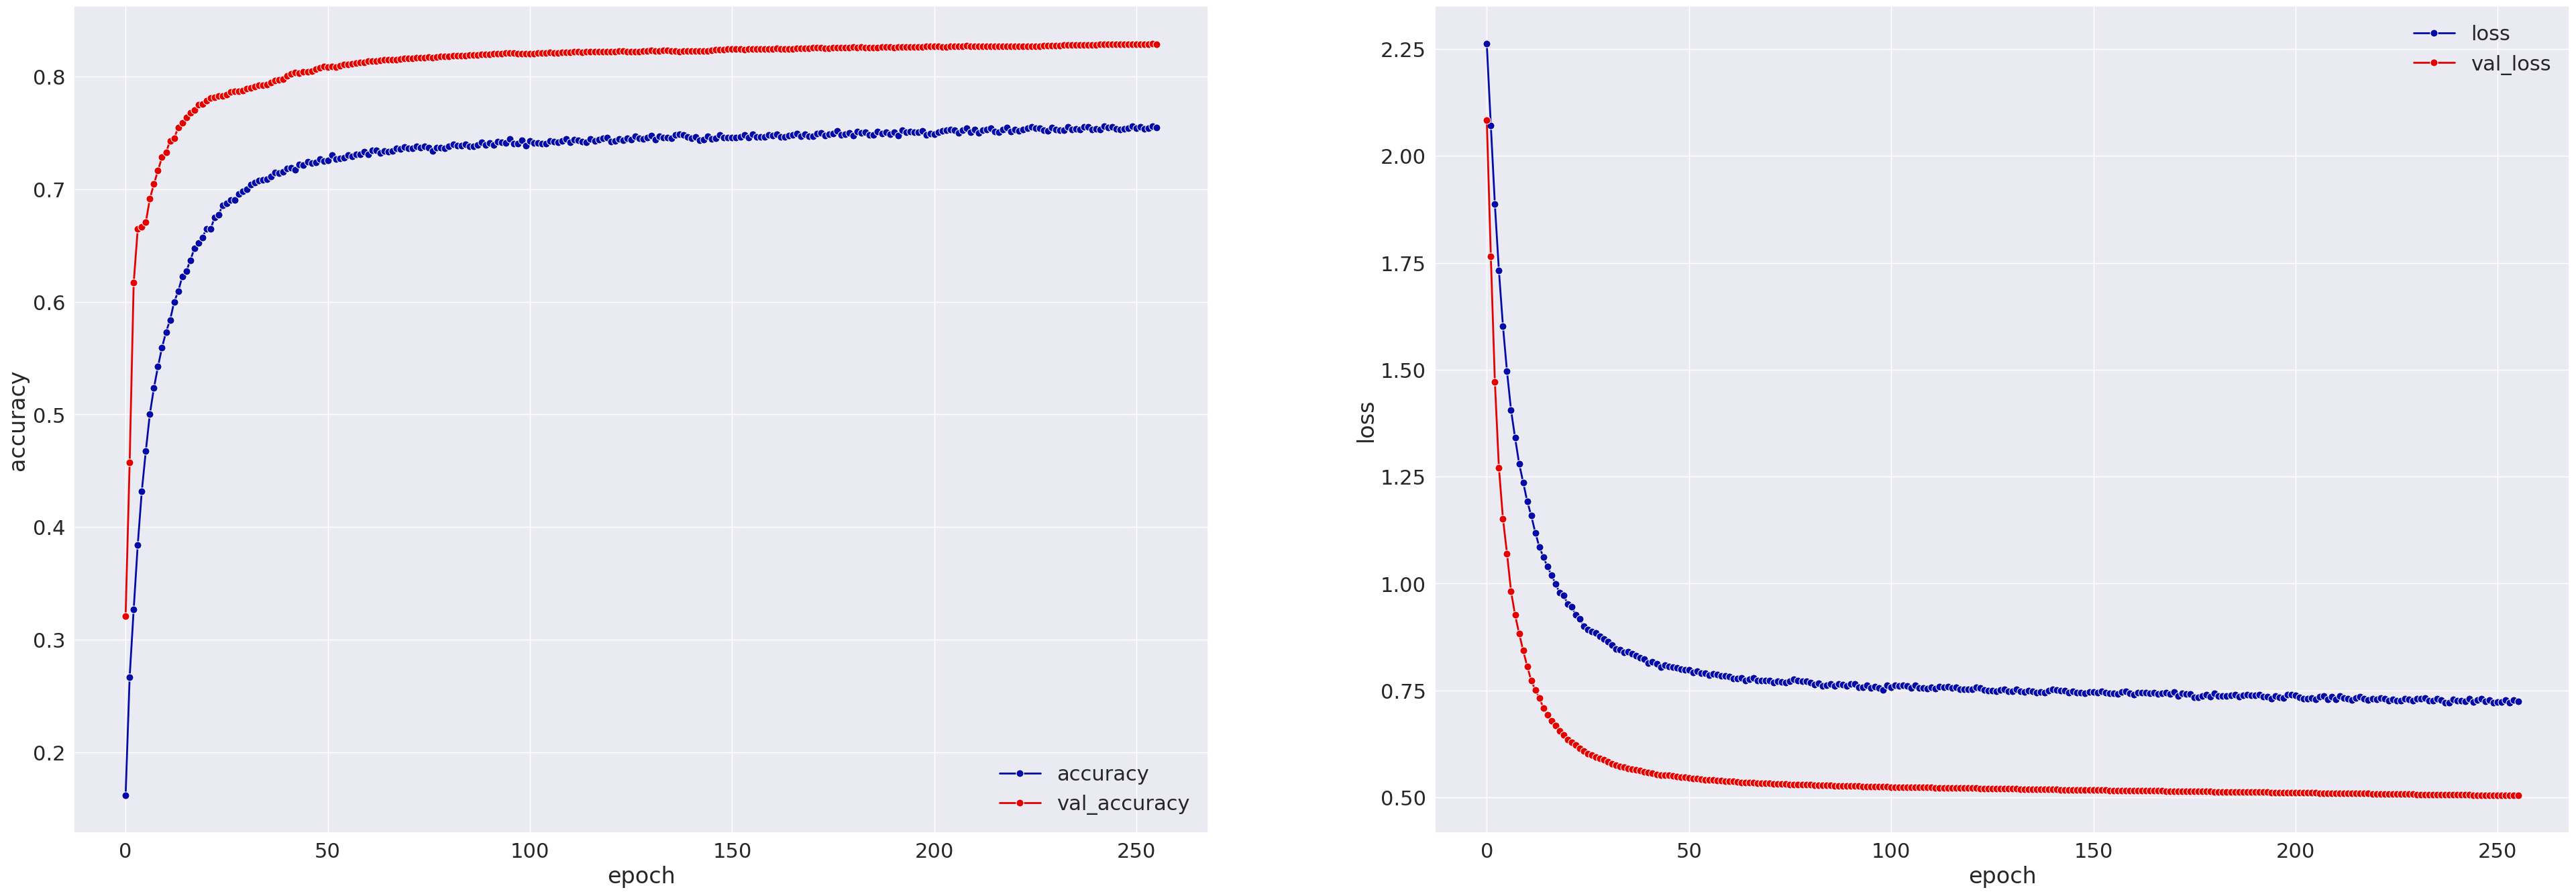

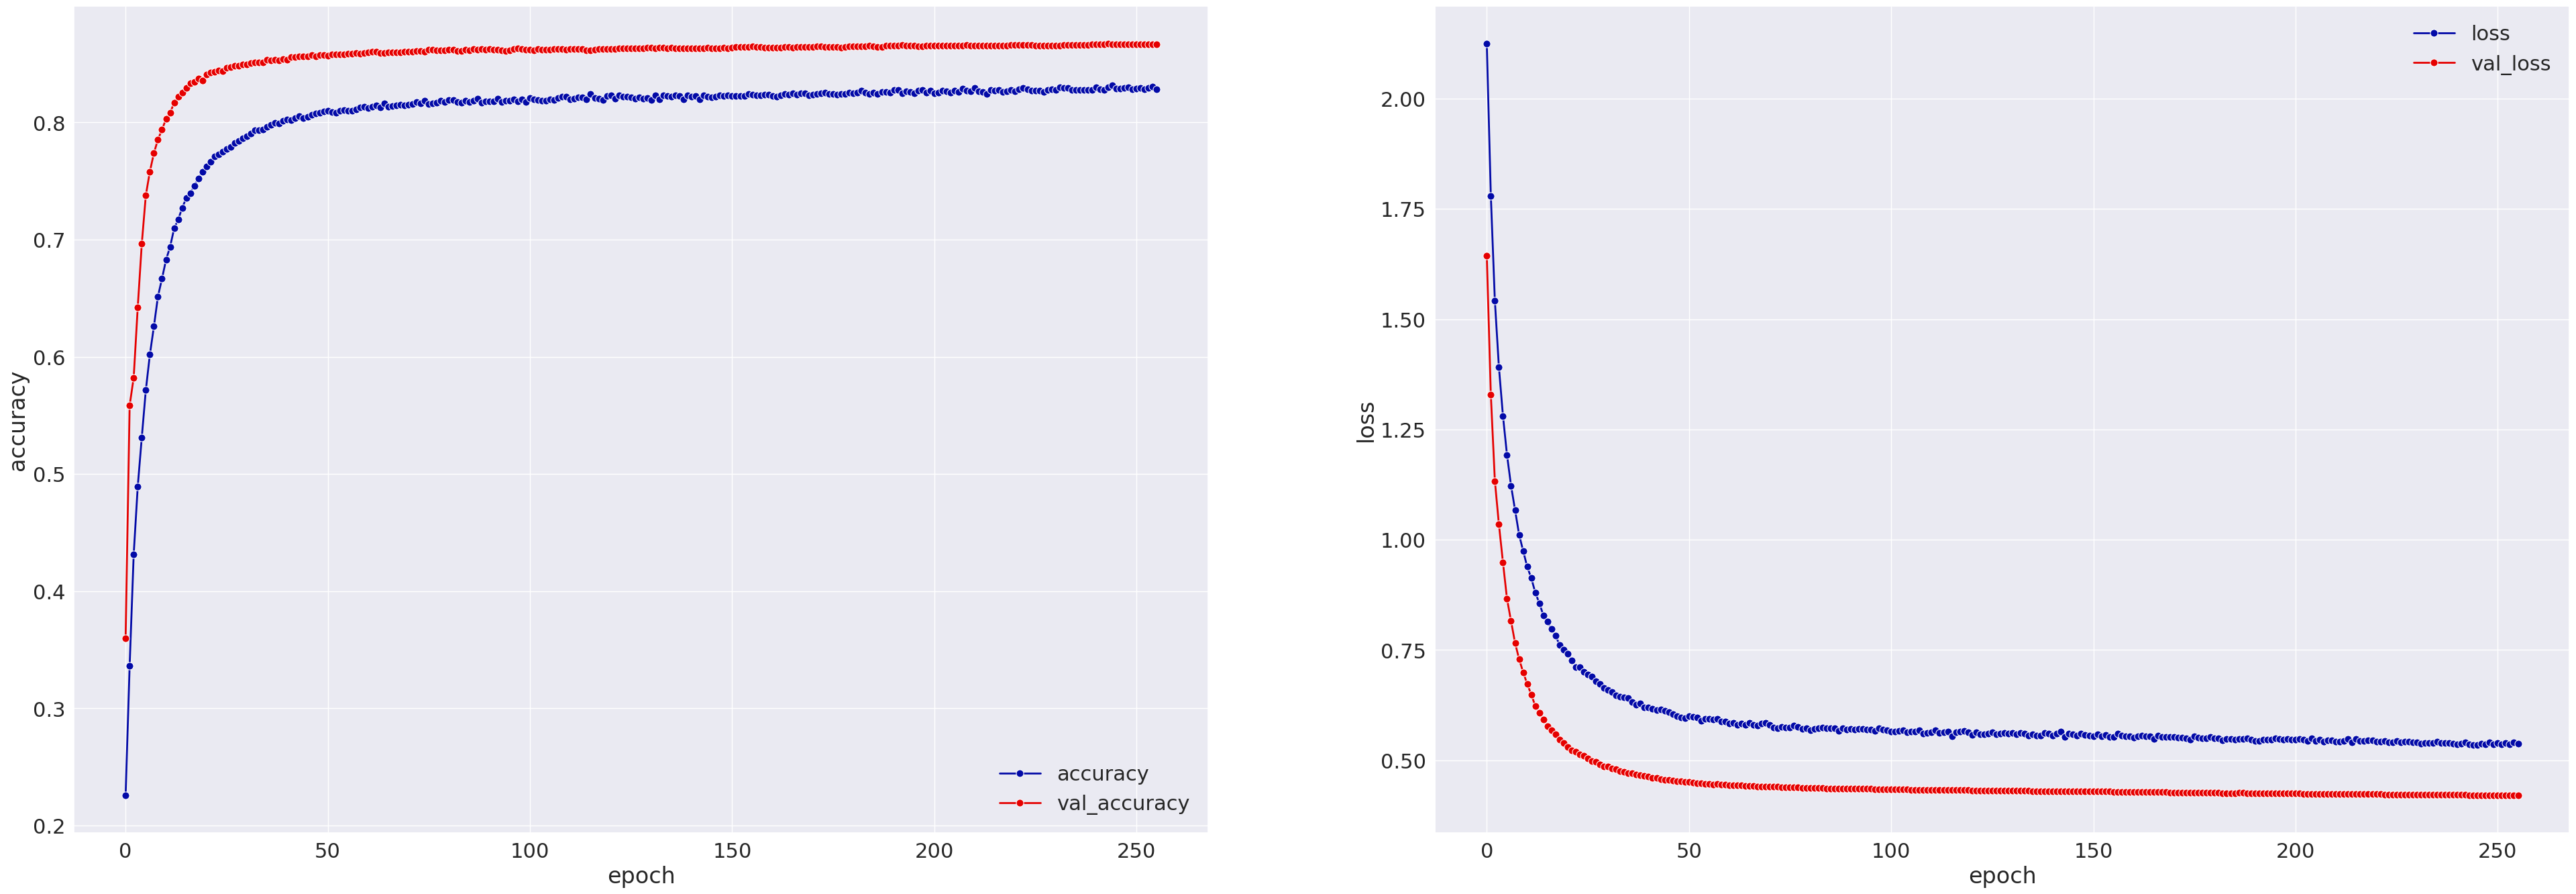

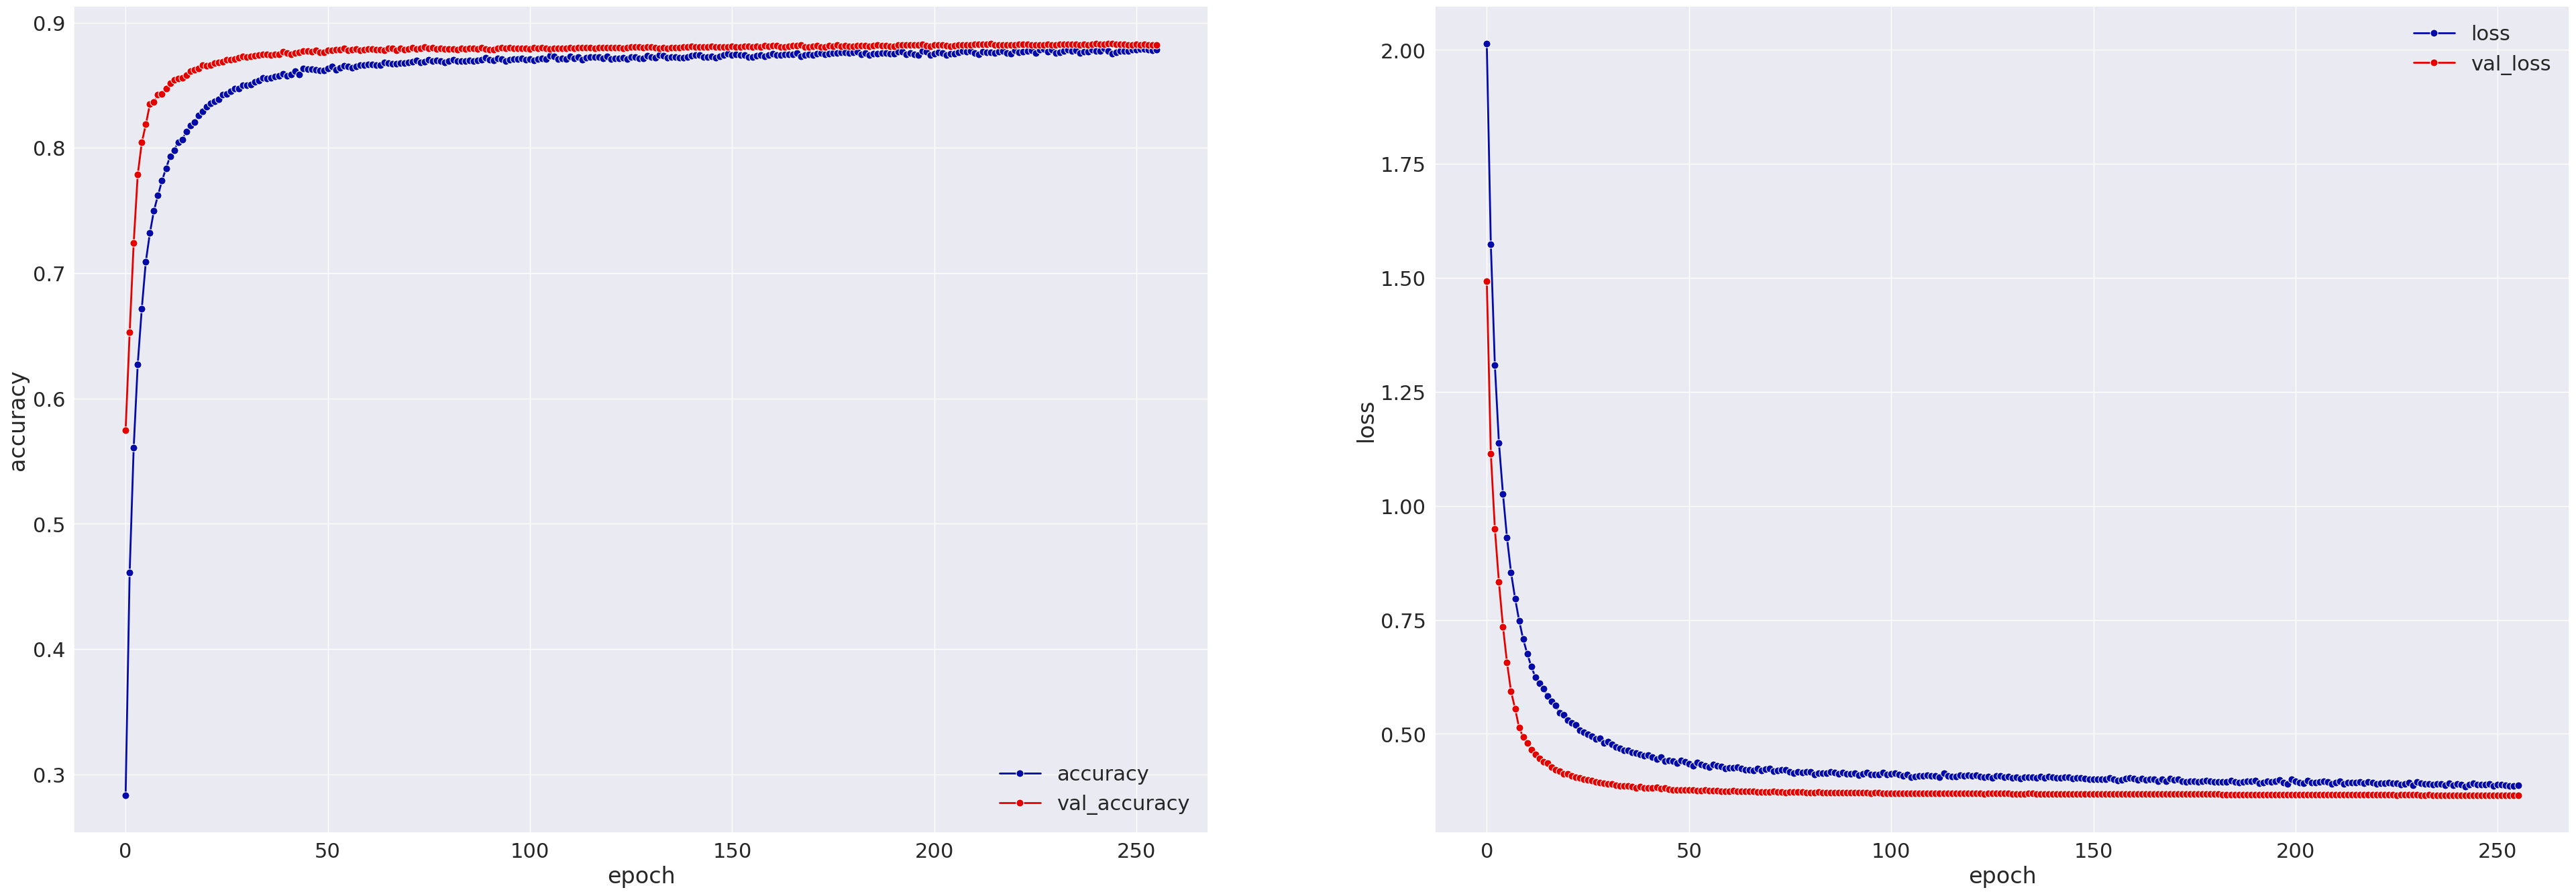

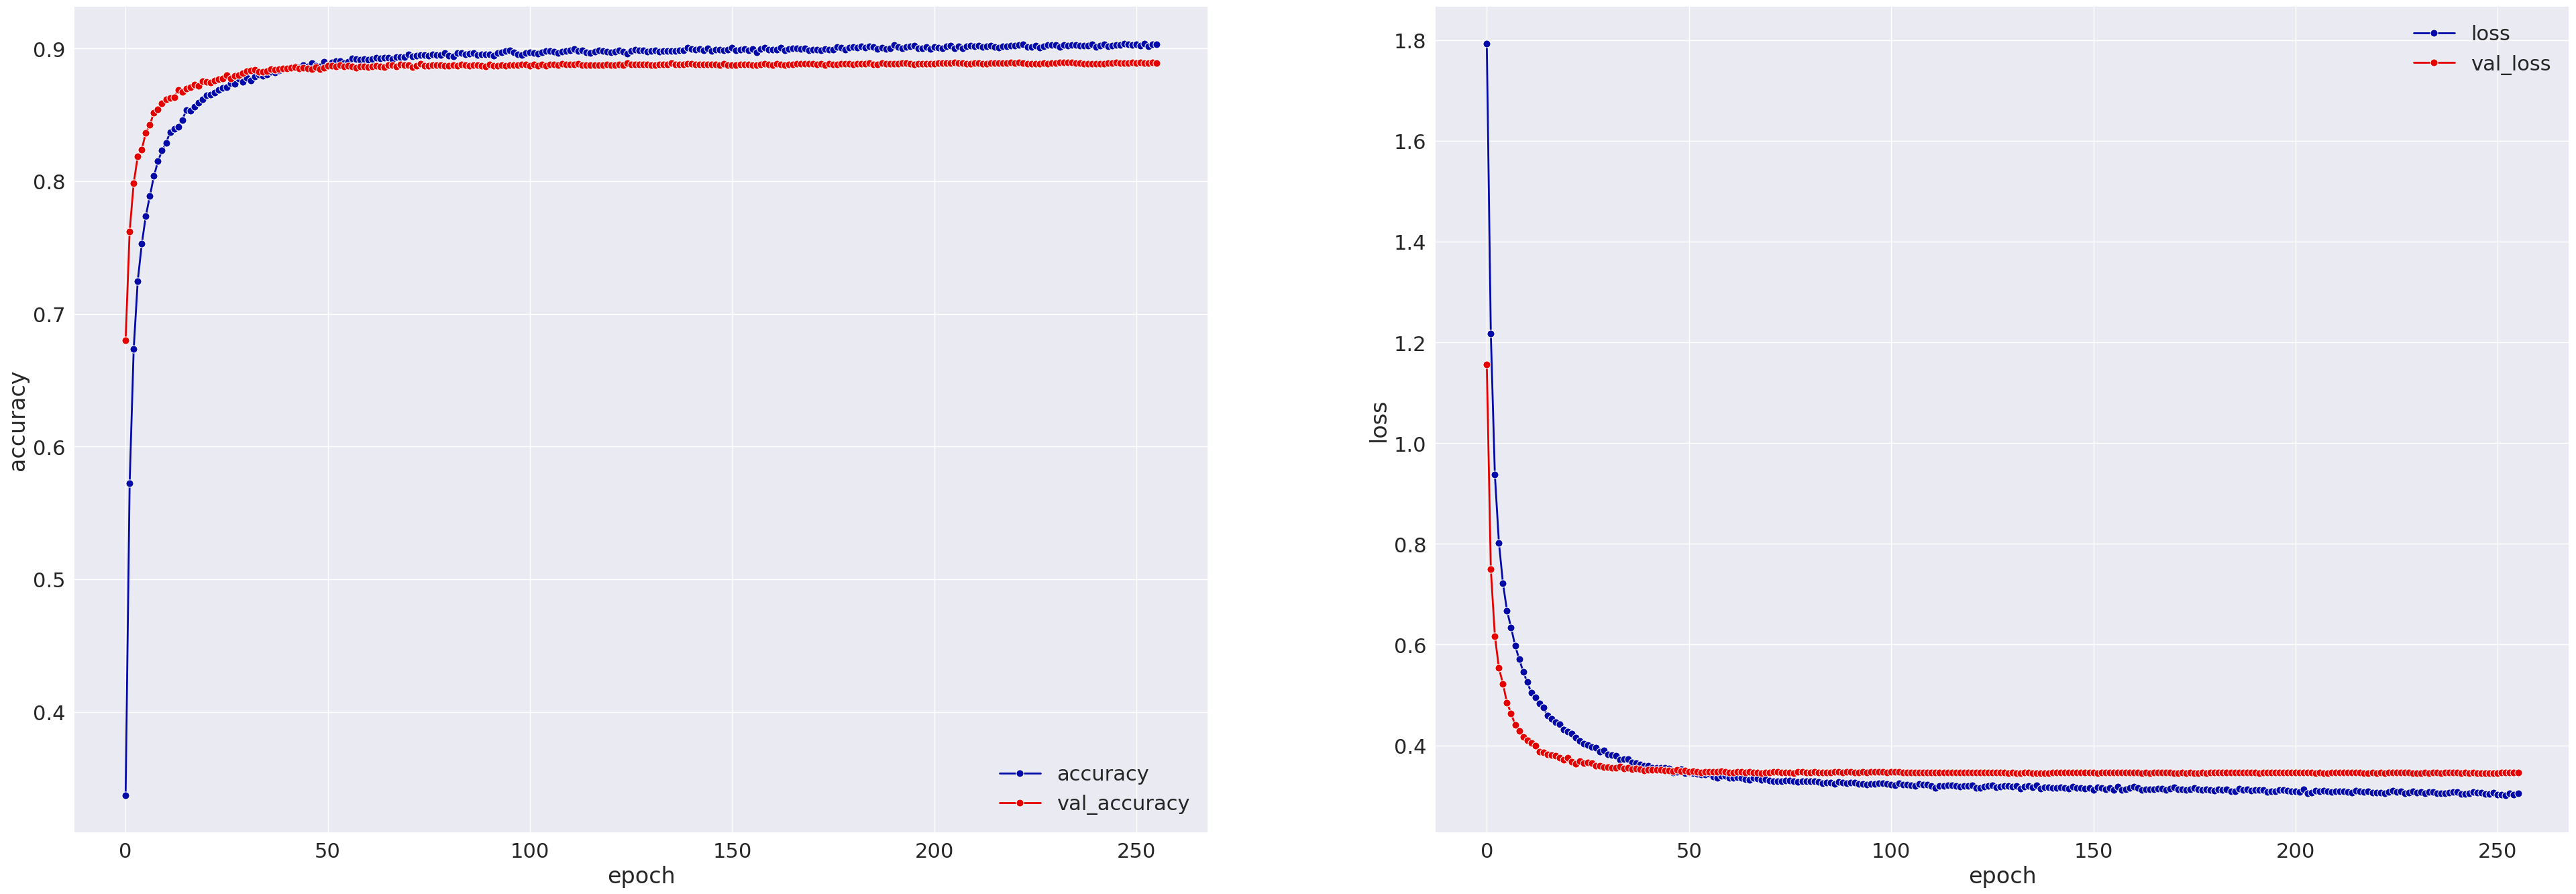

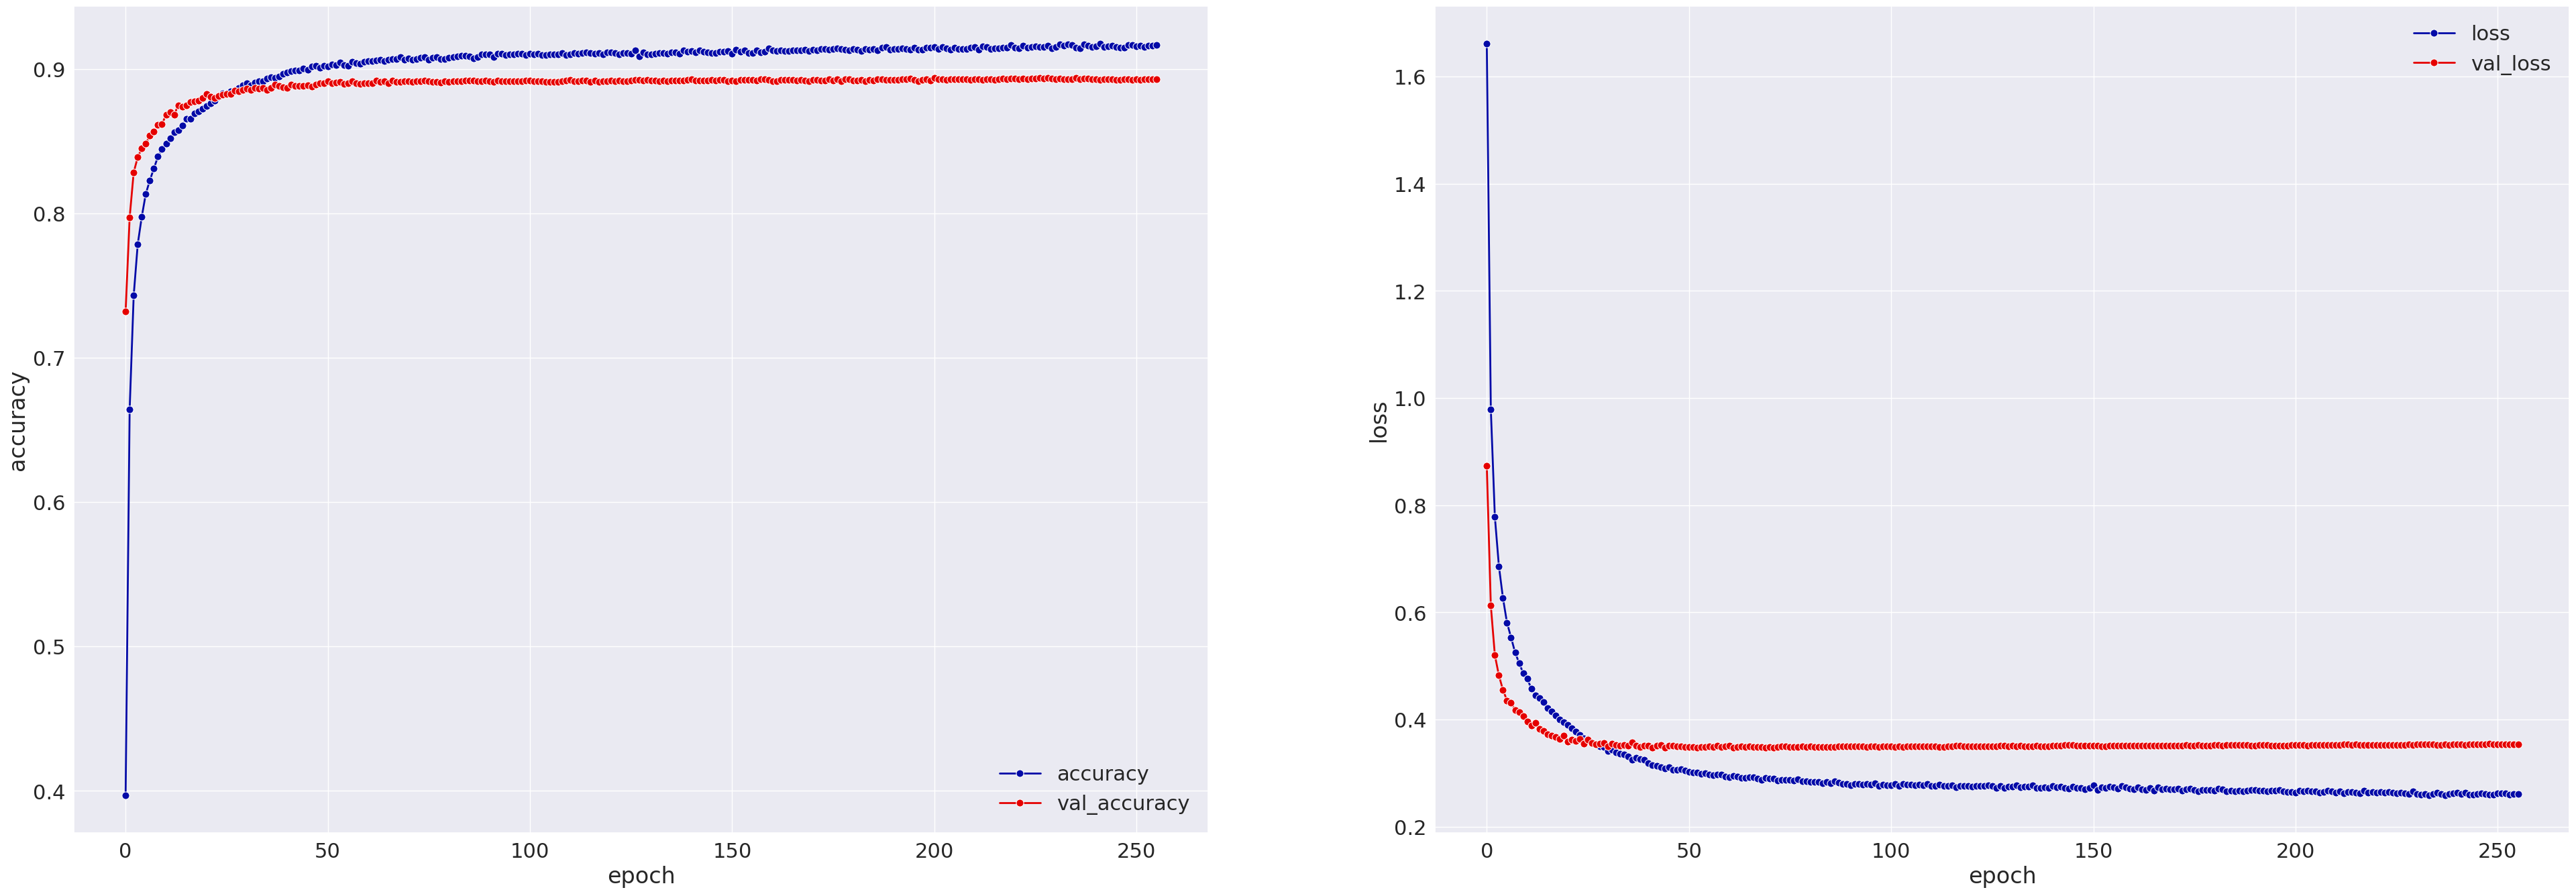

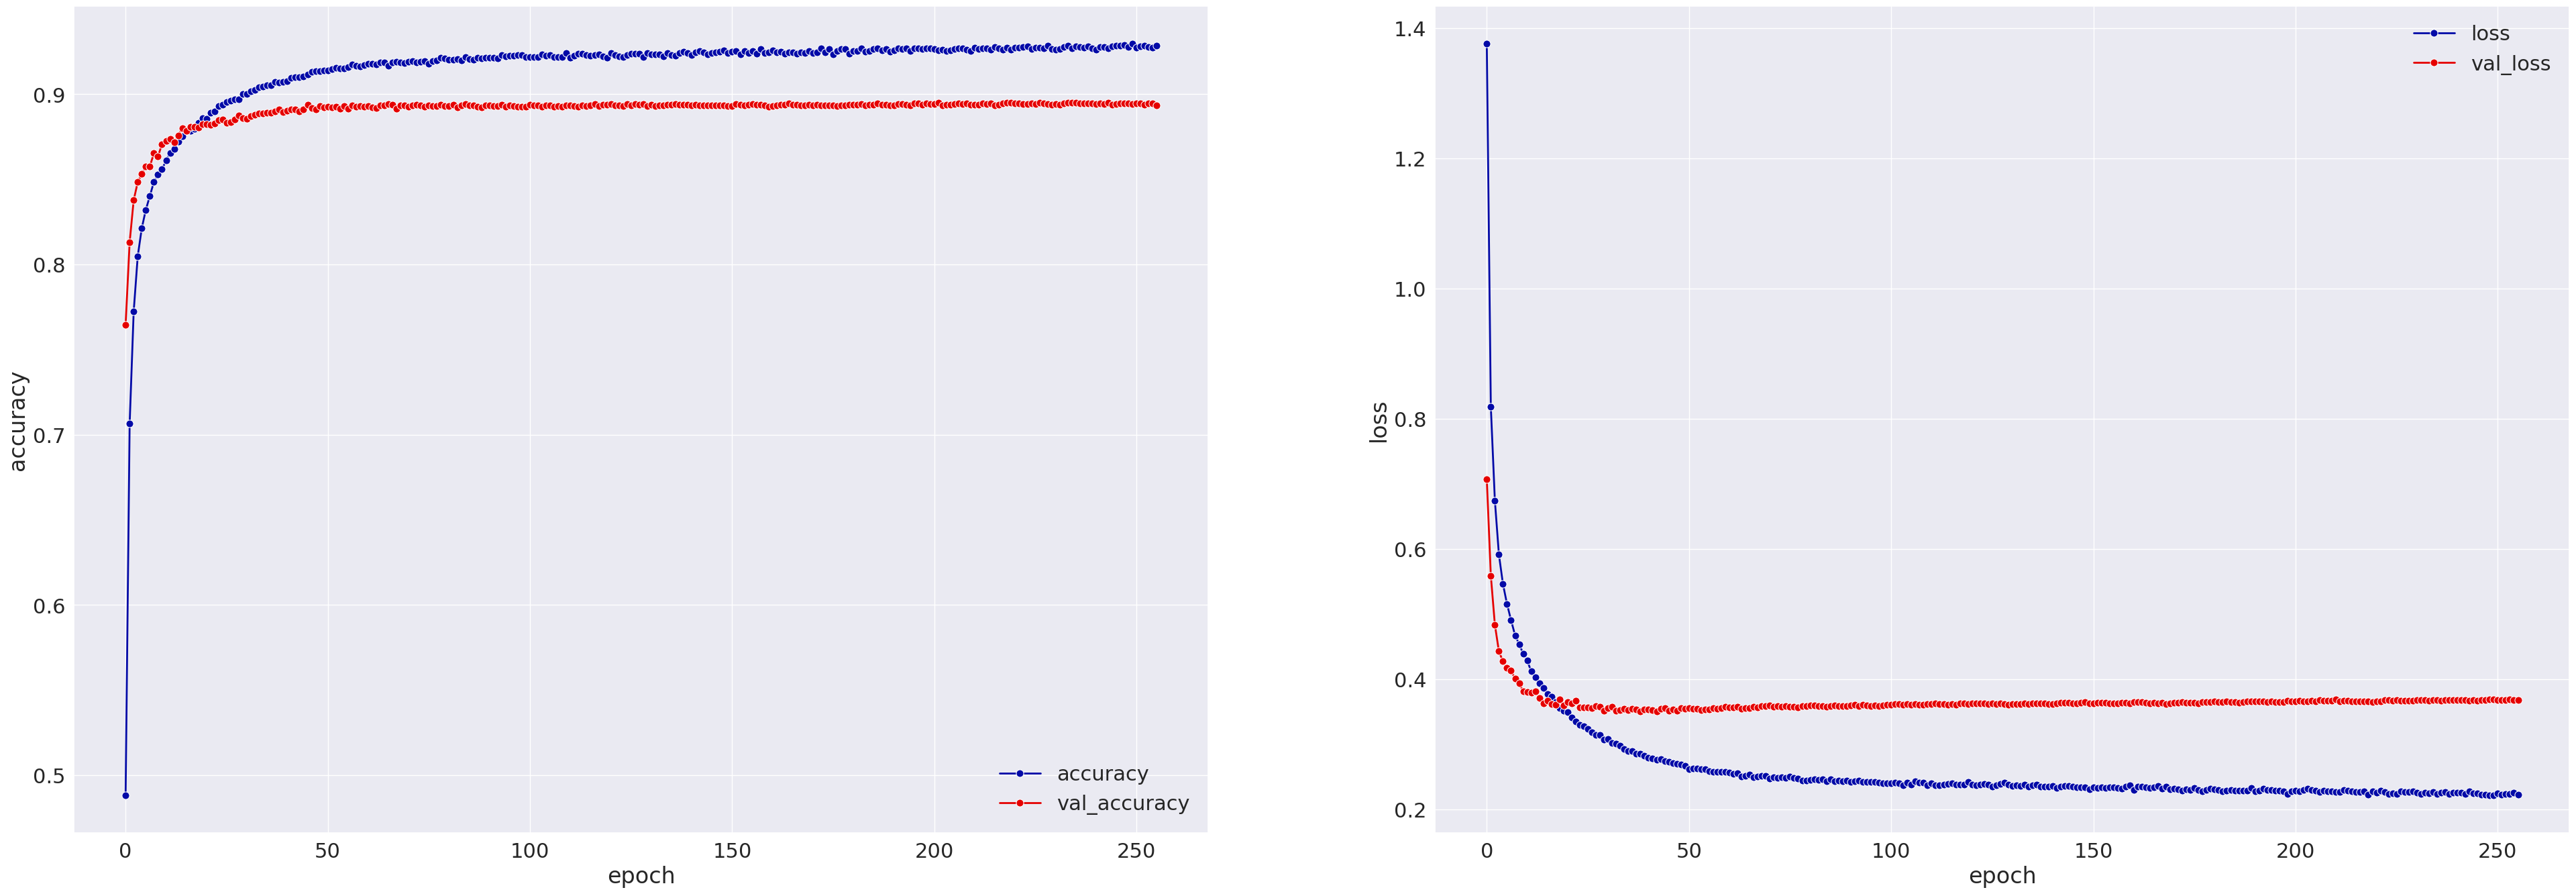

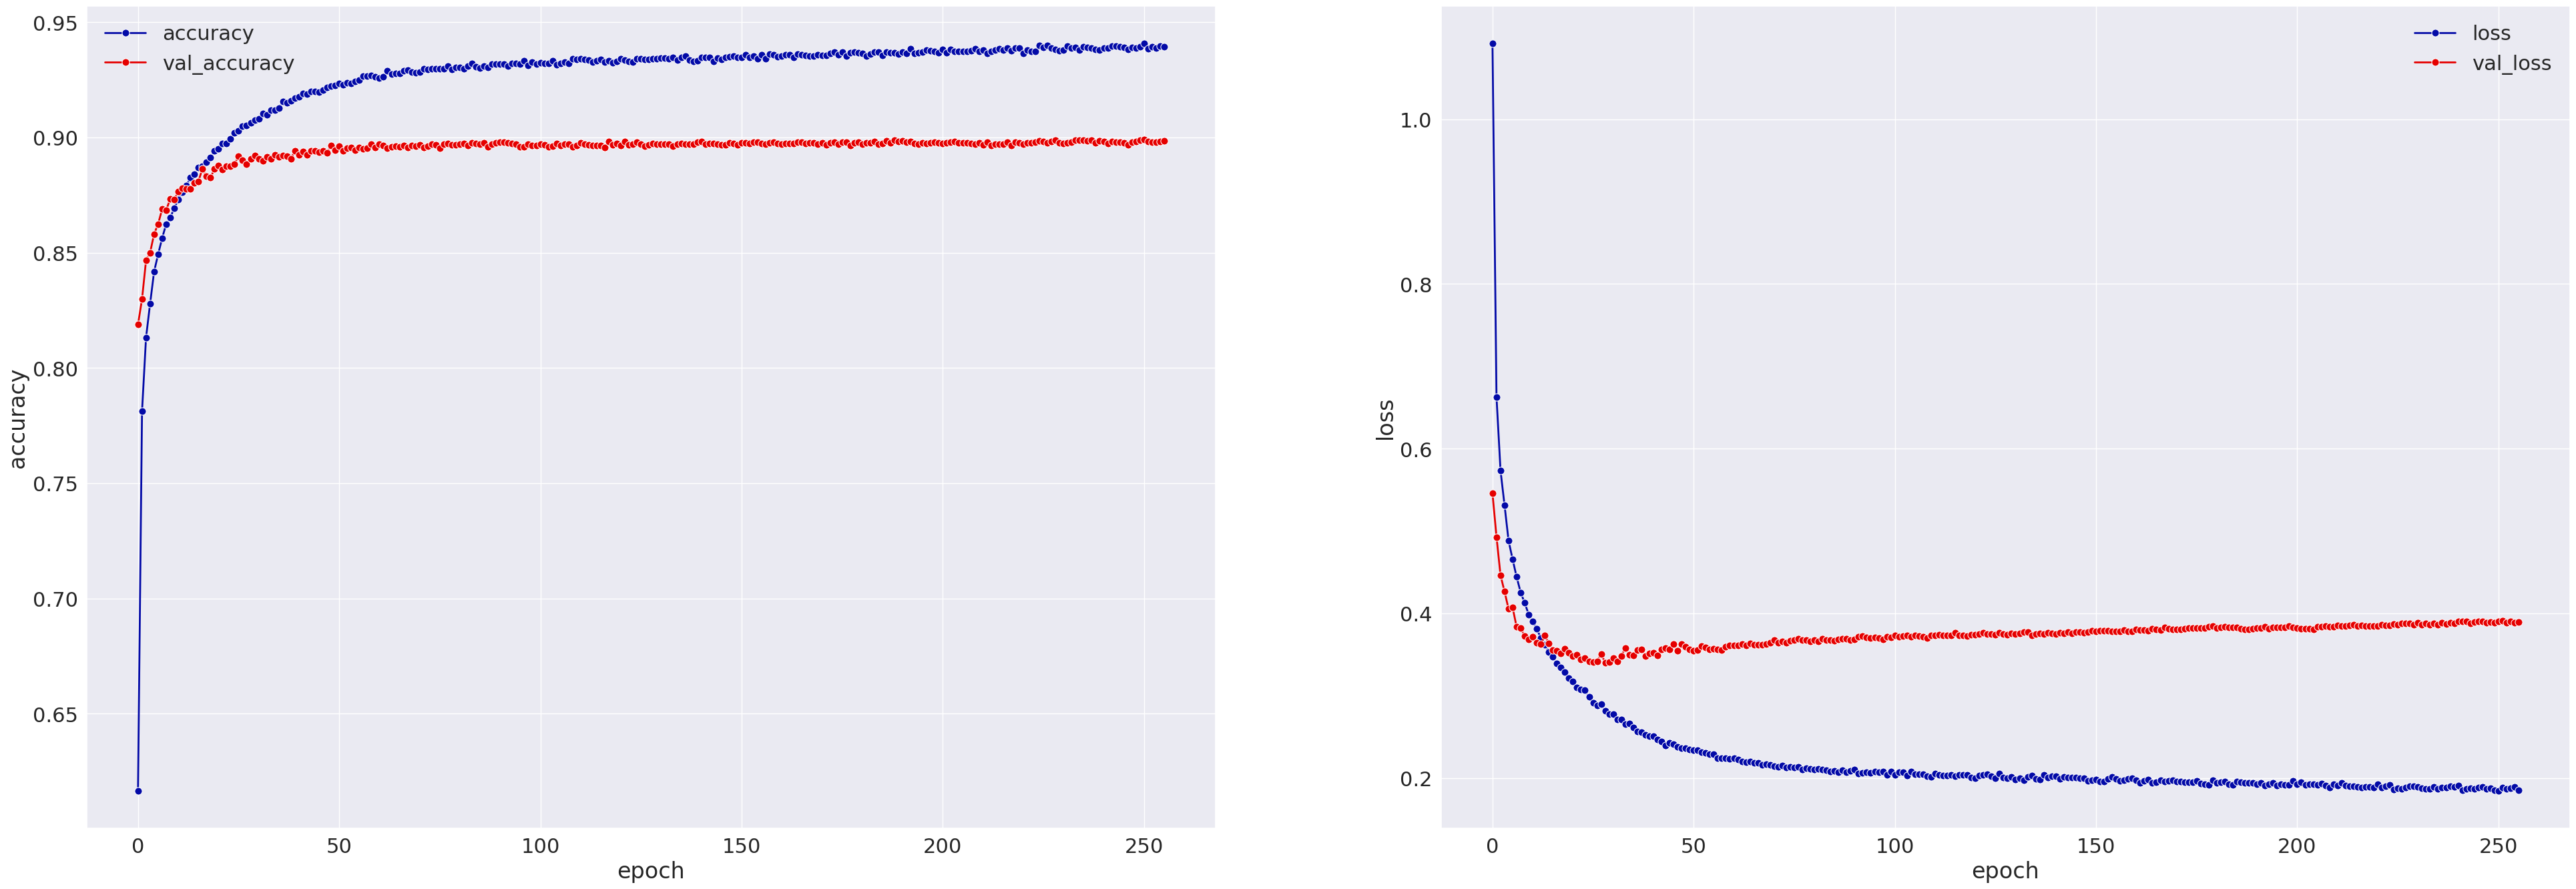

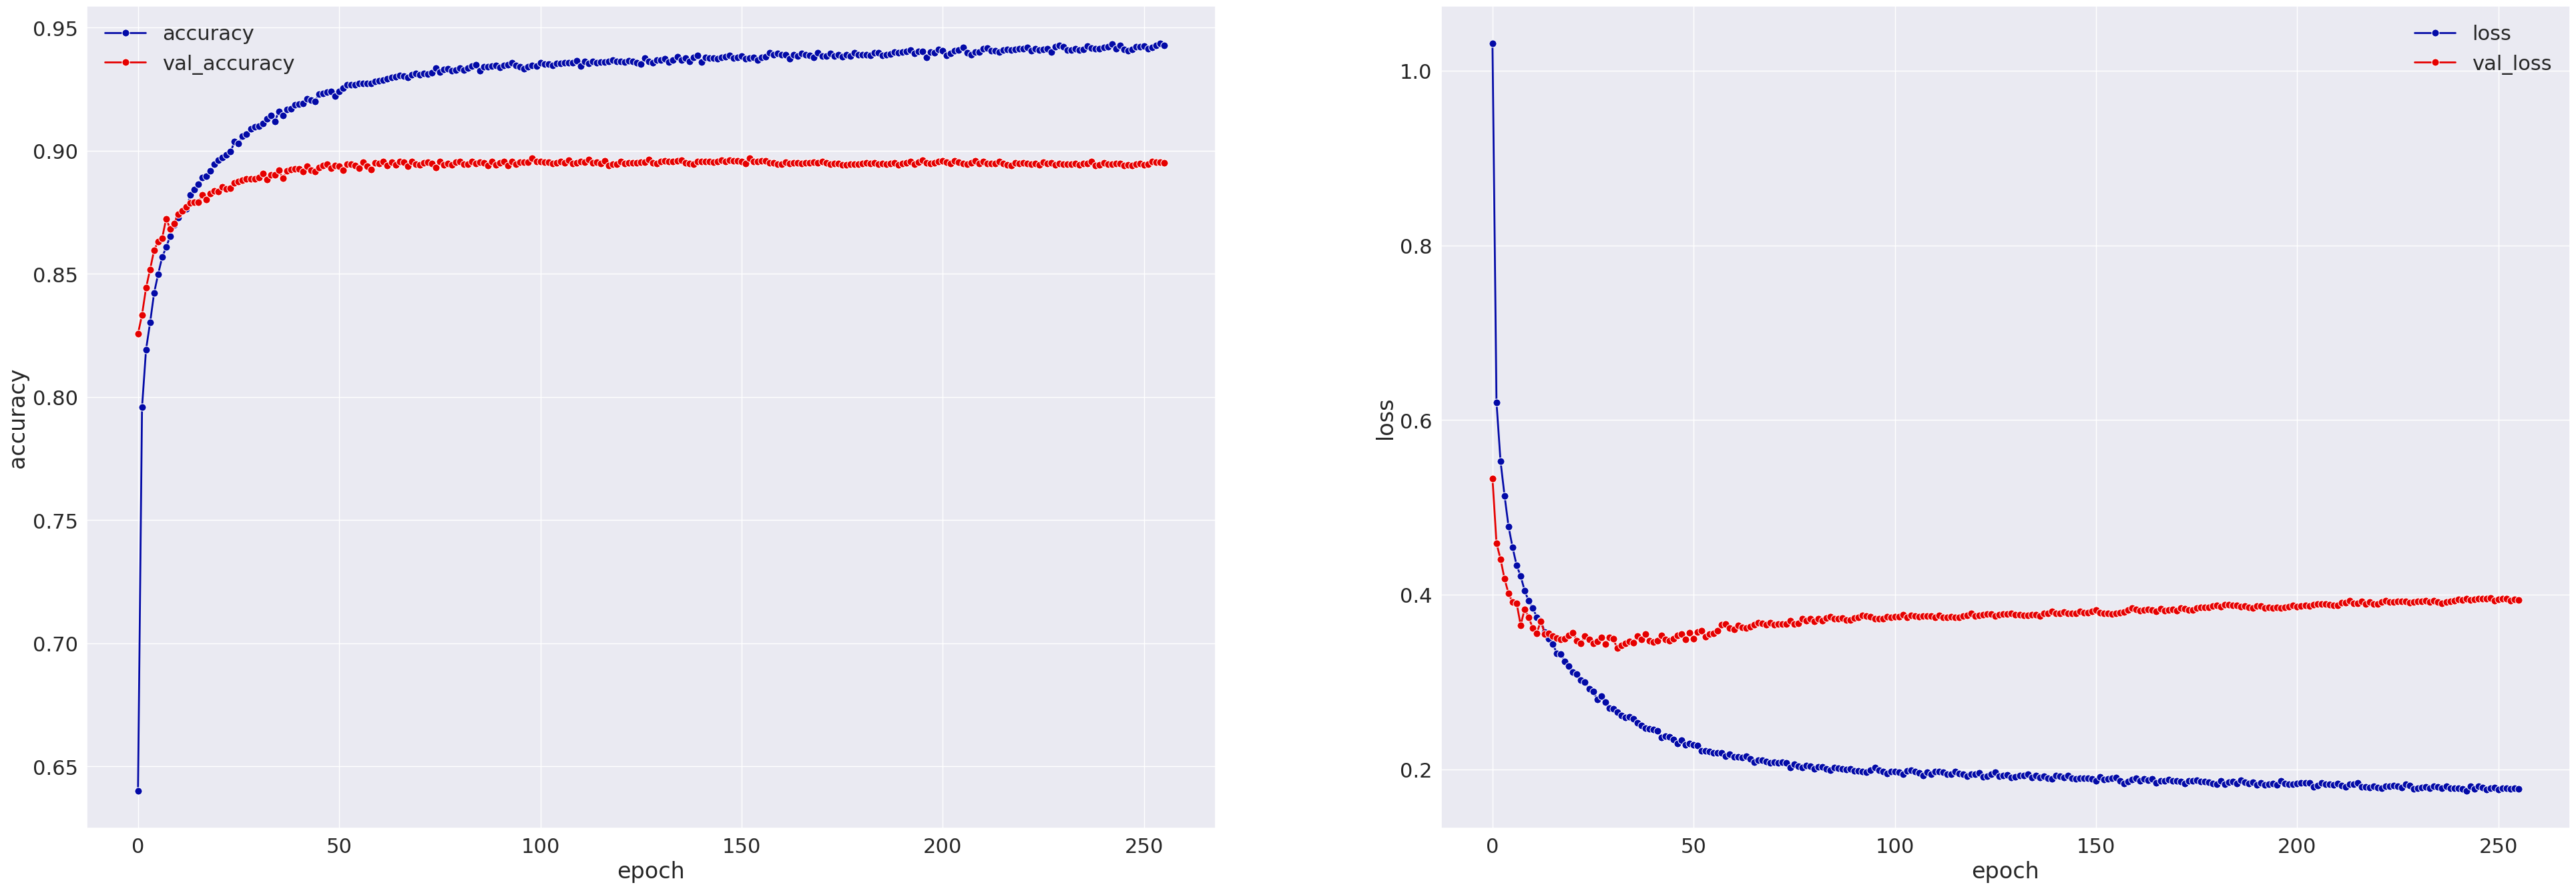

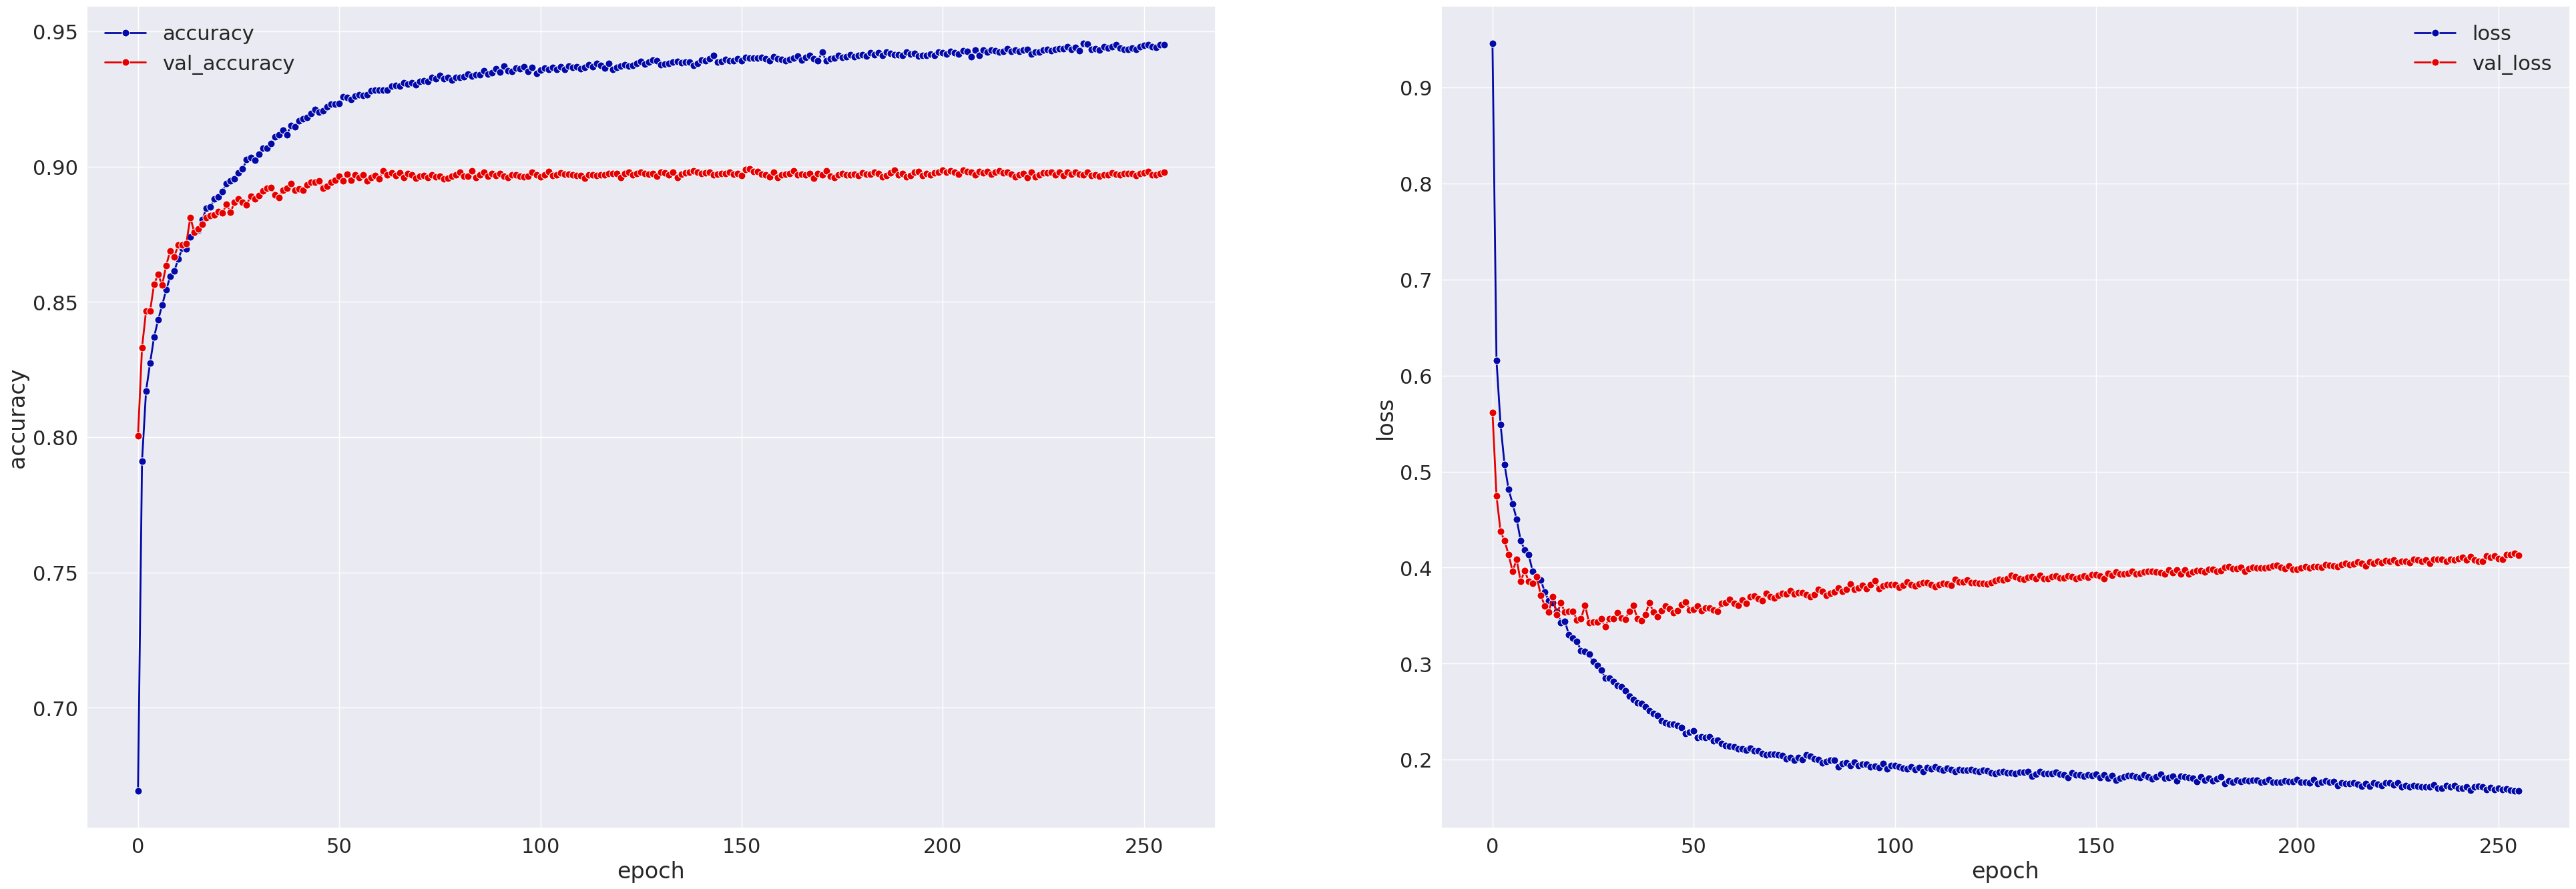

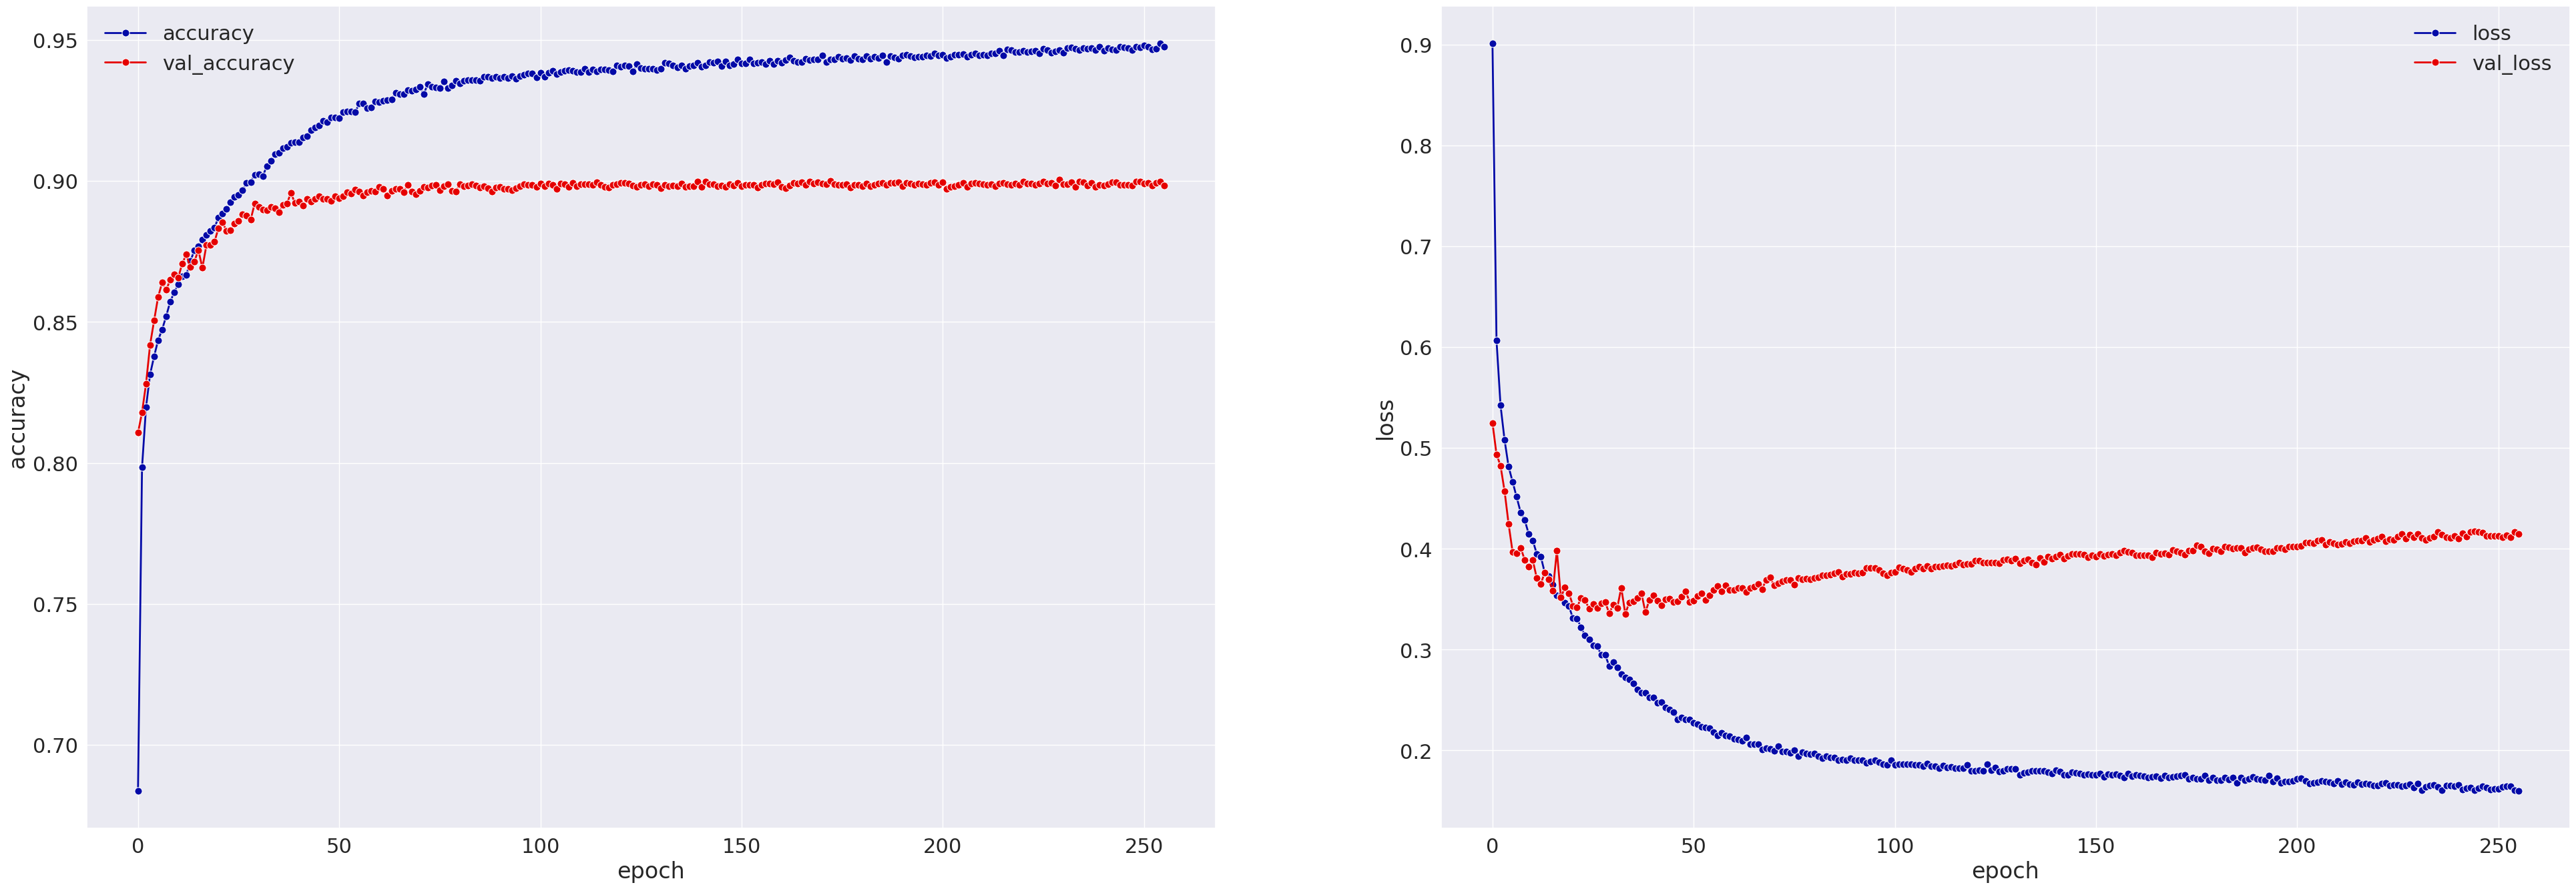

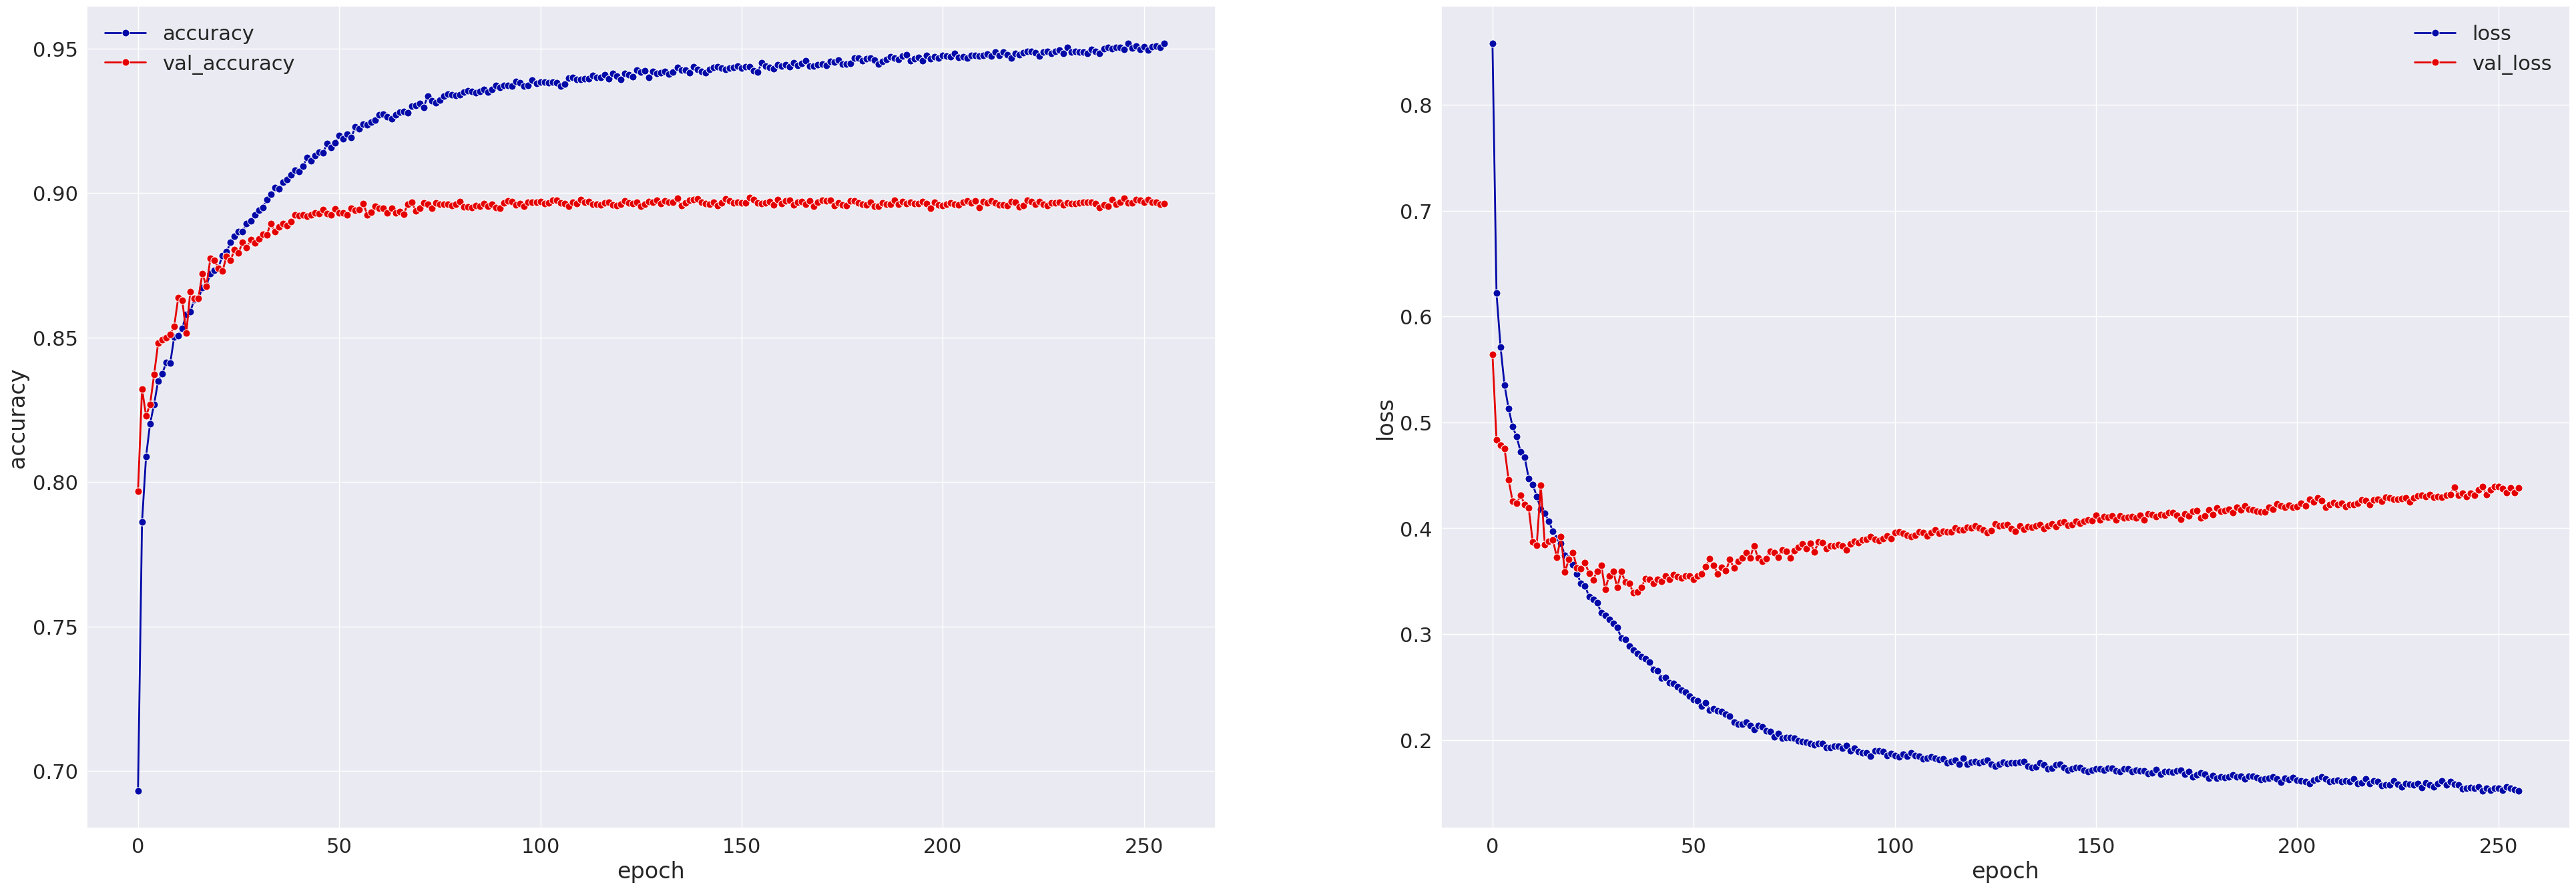

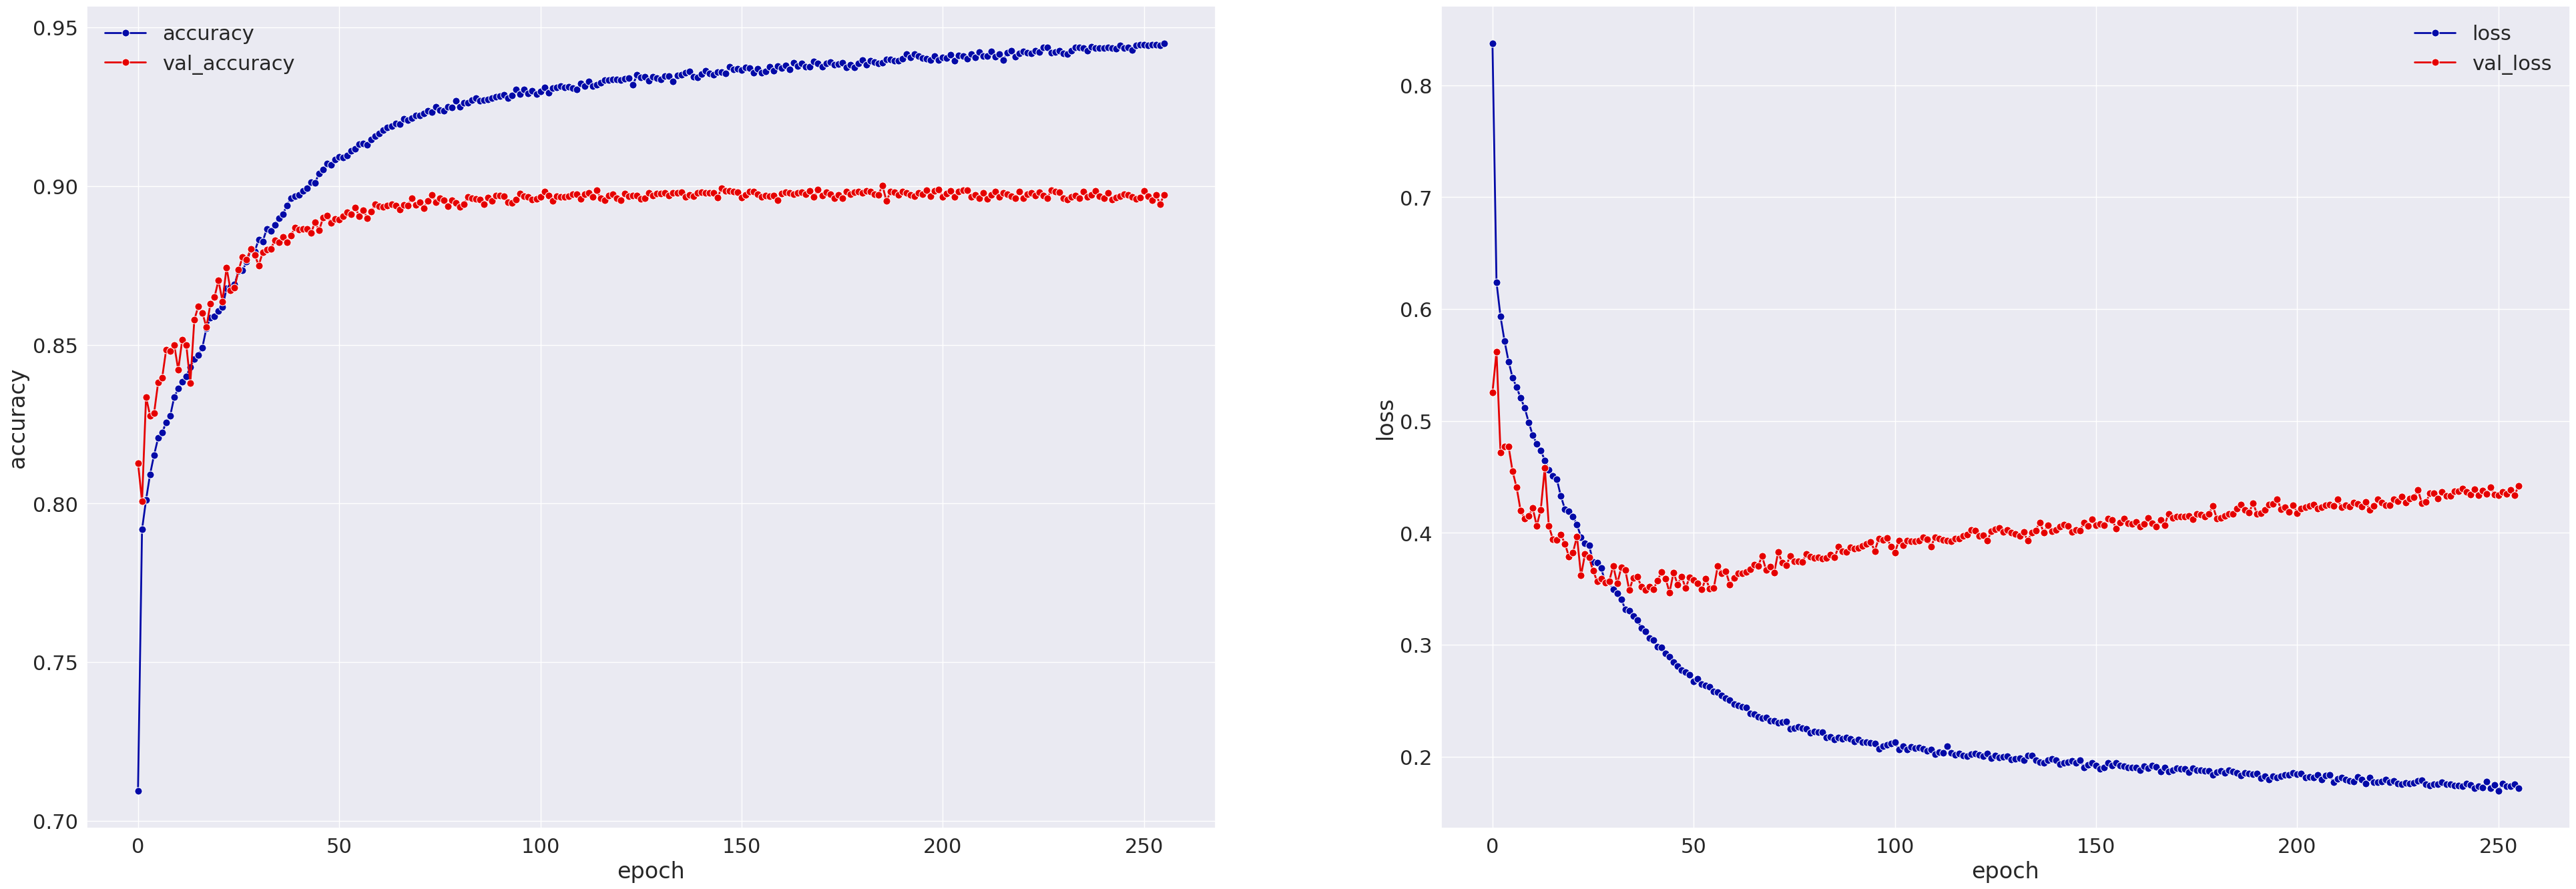

In [20]:
for i,batchsize in enumerate([32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128, 64, 32, 16, 8]):
    history = pd.DataFrame( history_list[i].history)
    history.reset_index(inplace=True)
    history.rename(columns={'index':'epoch'},inplace=True)
    afficheHistoriqueEntrainement(history, palette, nom=f'afficheHistoriqueEntrainement-{batchsize}')

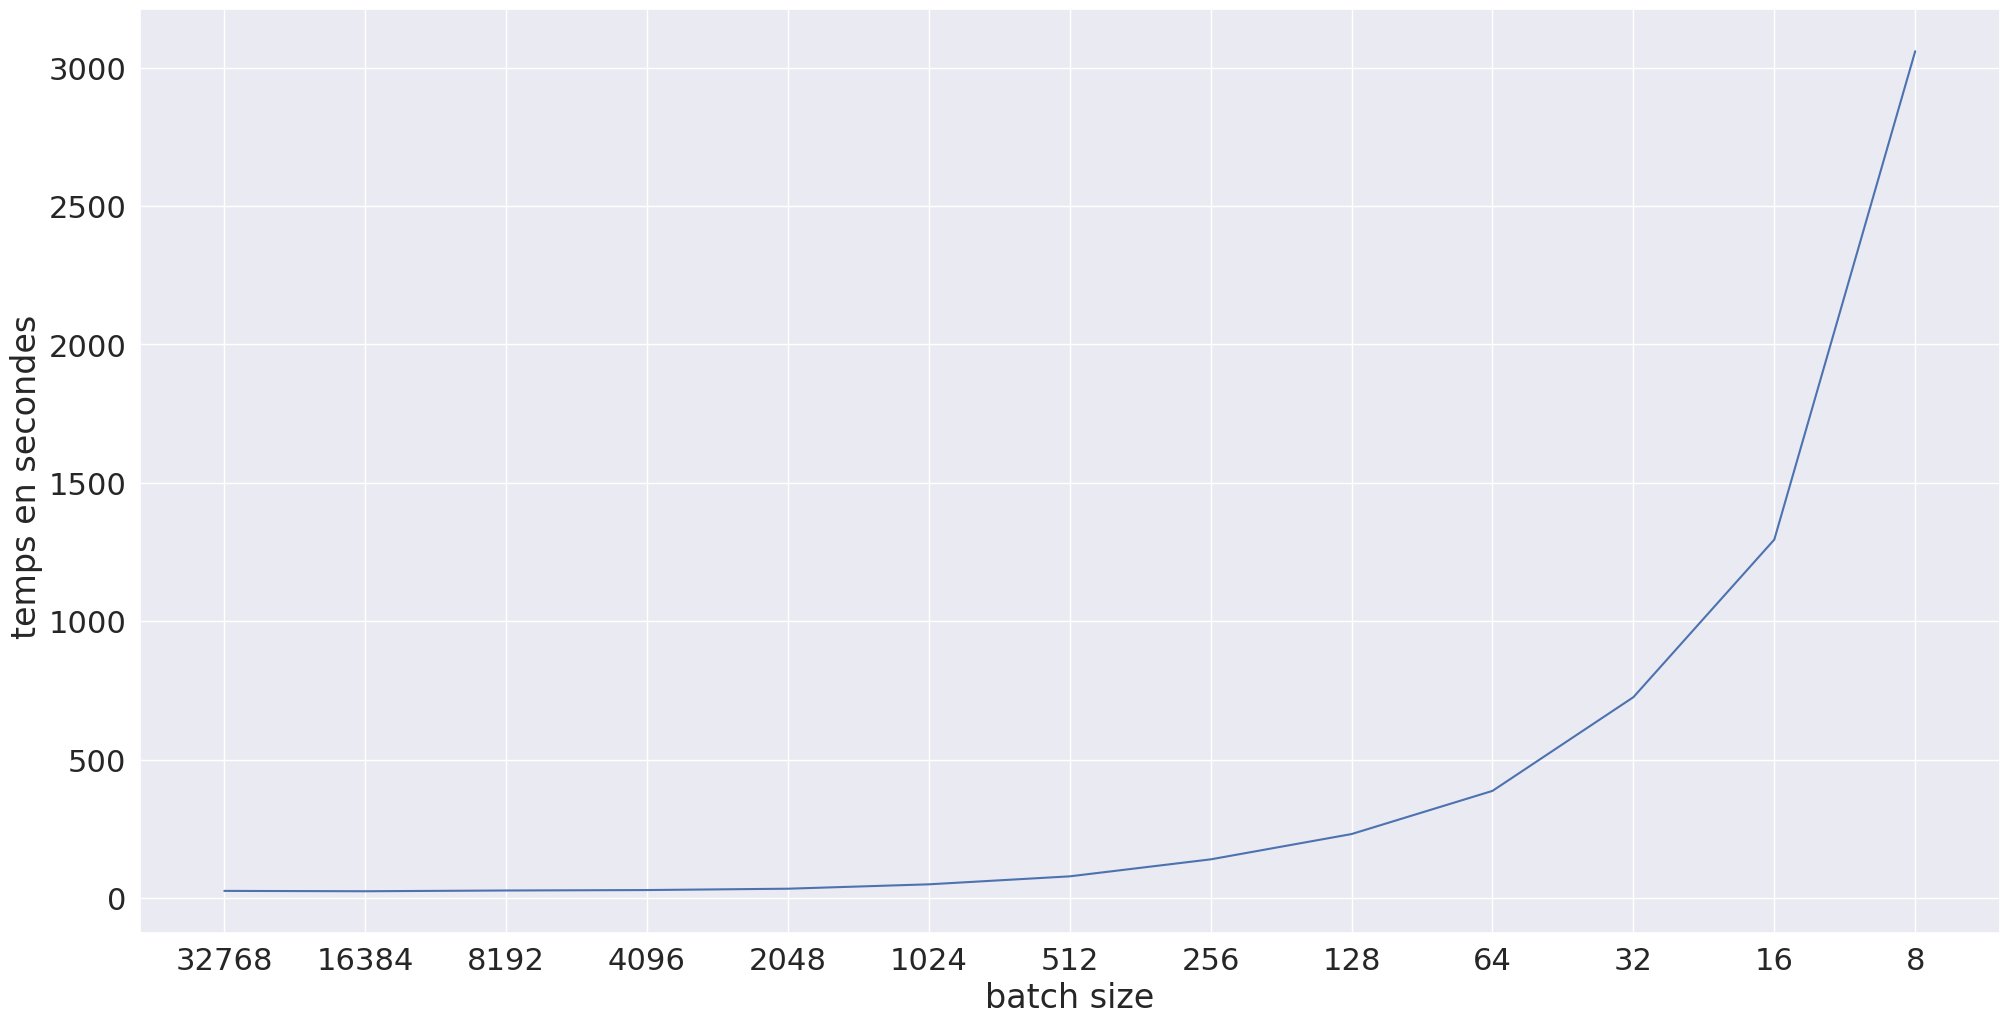

In [21]:
plt.figure(figsize=(24,12))
plt.plot(range(len(time_list)), time_list)
plt.xlabel('batch size')
plt.ylabel('temps en secondes ')
plt.xticks(range(len(time_list)), [32768,
                                   16384,
                                   8192 ,
                                   4096 ,
                                   2048 ,
                                   1024 ,
                                   512  ,
                                   256  ,
                                   128  ,
                                   64   ,
                                   32   ,
                                   16   ,
                                   8]);
sauvegarderImage('resultats_execution_apprentissage.batch-timing')